In [248]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime as dt
import time
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats import poisson
import scipy.stats as stats
%matplotlib inline

from google.oauth2.service_account import Credentials
import google_auth_httplib2
import pygsheets
import df2gspread as d2g
import googleapiclient
from googleapiclient  import discovery
from httplib2 import Http
from oauth2client import file, client, tools
from gspread_formatting.dataframe import format_with_dataframe, BasicFormatter
from gspread_formatting import Color
import logging

from oauth2client.service_account import ServiceAccountCredentials
from google.oauth2 import service_account
import gslides
from gslides import (Frame,Presentation,Spreadsheet,Table,Series,Chart)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2

In [ ]:
#gslides.initialize_credentials(creds) #BringYourOwnCredentials

In [2]:
# GBQ logging
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [3]:
# GBQ service account connection
# add path as a variable
# link DS to BG
credentials=Credentials.from_service_account_file('C:/Users/mncedisi.mncwabe/Downloads/tal-production-data-4390ad039b75.json')

In [256]:
# GBQ service account connection
cre_marketing=Credentials.from_service_account_file('C:/Users/mncedisi.mncwabe/Downloads/tal-production-marketing-e93d689c8a94_v2.json')

In [249]:
#gslides.initialize_credentials(credentials)

In [260]:
frame = Frame.create(df = df_pred.head(10),
          spreadsheet_id = '182yBKW_RmlXLQQCXtmwilftIGfNiRVv8lOwYUbrJ1n8',
          sheet_id = 'g132fb769c87_0_0',
          sheet_name = 'demo sheet',
          overwrite_data = True
)

HttpError: <HttpError 404 when requesting https://sheets.googleapis.com/v4/spreadsheets/182yBKW_RmlXLQQCXtmwilftIGfNiRVv8lOwYUbrJ1n8/values:batchUpdate?alt=json returned "Requested entity was not found.">

In [254]:
spr = Spreadsheet.create(
    spreadsheet_id = 'd/182yBKW_RmlXLQQCXtmwilftIGfNiRVv8lOwYUbrJ1n8',
    title = 'demo spreadsheet',
    sheet_names = ['demo sheet']
)

TypeError: create() got an unexpected keyword argument 'spreadsheet_id'

### ADD BH Level1 - customer Level 1 - to be used for clustering

In [ ]:
# put dynamic variables

In [13]:
start_time = time.time()

query_no_lvl1 = '''

SELECT y.customer_id, y.FY,y.Division,
CASE WHEN y.FY="FY20" THEN DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY) 
     WHEN y.FY="FY21" THEN DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
     ELSE DATE_DIFF(CAST("2022-04-30"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
END AS Recency, SUM(y.Frequency) AS Frequency, SUM(y.Monetary) AS Monetary,
CASE 
     WHEN (DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY))=0 
     THEN   (IF(y.FY="FY20",DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY), 
             IF(y.FY="FY21", DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
            ,DATE_DIFF(CAST("2022-04-30"AS DATE),MAX(DATE(y.Auth_Date)),DAY))))
     WHEN y.FY="FY20" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
     WHEN y.FY="FY21" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
ELSE DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
END AS Duration
FROM 
(
SELECT
     customer_id,
     x.Auth_Date,
     CASE WHEN DATE(x.Auth_Date) >= '2019-04-01' AND DATE(x.Auth_Date) < '2020-04-01' THEN "FY20"
          WHEN DATE(x.Auth_Date) >= '2020-04-01' AND DATE(x.Auth_Date) < '2021-04-01' THEN "FY21"
          WHEN DATE(x.Auth_Date) >= '2021-04-01' AND DATE(x.Auth_Date) < '2022-04-01' THEN "FY22"
      END AS FY,
      #FORMAT_DATE("%Y-%m",x.Auth_Date) AS YearMonth,
      x.Division,
      /*x.Department,
       x.Level1,*/
      DATE_DIFF(CAST("2022-04-30" AS DATE),MAX(DATE(x.Auth_Date)),DAY) AS Recency,
      COUNT(DISTINCT x.order_id) AS Frequency,
      ROUND(SUM(x.order_item_sales),2) AS Monetary,
      IF((DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))=0,
      DATE_DIFF(CAST("2022-04-30" AS DATE),MAX(DATE(x.Auth_Date)),DAY),(DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))) AS Duration
FROM (      
SELECT  DISTINCT o.customer_id,
        bh.bh_division AS Division, 
        /*bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,*/
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2010_2020` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2019-04-01" AND DATE(o.order_placed_timestamp) < "2020-01-01" 
        AND DATE(o.order_authed_timestamp) >= "2019-04-01" AND DATE(o.order_authed_timestamp) < "2020-01-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'

UNION ALL

SELECT DISTINCT o.customer_id,
        bh.bh_division AS Division, 
        /*bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,*/
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2020-01-01" AND DATE(o.order_placed_timestamp) < "2022-05-01" 
        AND DATE(o.order_authed_timestamp) >= "2020-01-01" AND DATE(o.order_authed_timestamp) < "2022-05-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped') x
    GROUP BY 1,2,3,4
    ORDER BY Auth_Date ASC) y
    WHERE y.FY IS NOT NULL
    GROUP BY 1,2,3
'''
df_no_lvl1 = pd.read_gbq(query_no_lvl1, project_id='gcp-takealot', dialect='standard', credentials=credentials,progress_bar_type='tqdm_notebook')

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-05-25 19:54:46,985 : DEBUG : Requesting query... 
Query running...
2022-05-25 19:54:51,352 : DEBUG : Query running...
Job ID: 0ff9963f-eacb-40b5-9a30-0120d18fb3c0
2022-05-25 19:54:51,352 : DEBUG : Job ID: 0ff9963f-eacb-40b5-9a30-0120d18fb3c0
  Elapsed 14.46 s. Waiting...
2022-05-25 19:55:01,449 : INFO :   Elapsed 14.46 s. Waiting...
  Elapsed 24.59 s. Waiting...
2022-05-25 19:55:11,577 : INFO :   Elapsed 24.59 s. Waiting...
  Elapsed 34.69 s. Waiting...
2022-05-25 19:55:21,674 : INFO :   Elapsed 34.69 s. Waiting...
Query done.
Processed: 7.1 GB Billed: 7.1 GB
2022-05-25 19:55:29,344 : DEBUG : Query done.
Processed: 7.1 GB Billed: 7.1 GB
Standard price: $0.03 USD

2022-05-25 19:55:29,344 : DEBUG : Standard price: $0.03 USD



Downloading:   0%|          | 0/17707575 [00:00<?, ?rows/s]

Got 17707575 rows.

2022-05-25 20:11:47,085 : DEBUG : Got 17707575 rows.

Total time taken 1020.1 s.
Finished at 2022-05-25 20:11:47.
2022-05-25 20:11:47,086 : INFO : Total time taken 1020.1 s.
Finished at 2022-05-25 20:11:47.


--- 1020.7992706298828 seconds ---


In [7]:
start_time = time.time()

query_with_lvl1 = '''

SELECT y.customer_id,y.FY,y.Division,y.Department, y.Level1,
CASE WHEN y.FY="FY20" THEN DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY) 
     WHEN y.FY="FY21" THEN DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
     ELSE DATE_DIFF(CAST("2022-04-30"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
END AS Recency, SUM(y.Frequency) AS Frequency, SUM(y.Monetary) AS Monetary,
CASE 
     WHEN (DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY))=0 
     THEN   (IF(y.FY="FY20",DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY), 
             IF(y.FY="FY21", DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
            ,DATE_DIFF(CAST("2022-04-30"AS DATE),MAX(DATE(y.Auth_Date)),DAY))))
     WHEN y.FY="FY20" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
     WHEN y.FY="FY21" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
ELSE DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
END AS Duration
FROM 
(
SELECT
     customer_id,
     x.Auth_Date,
     CASE WHEN DATE(x.Auth_Date) >= '2019-04-01' AND DATE(x.Auth_Date) < '2020-04-01' THEN "FY20"
          WHEN DATE(x.Auth_Date) >= '2020-04-01' AND DATE(x.Auth_Date) < '2021-04-01' THEN "FY21"
          WHEN DATE(x.Auth_Date) >= '2021-04-01' AND DATE(x.Auth_Date) < '2022-04-01' THEN "FY22"
      END AS FY,
      #FORMAT_DATE("%Y-%m",x.Auth_Date) AS YearMonth,
      x.Division,
      Department,
       x.Level1,
      DATE_DIFF(CAST("2022-04-30" AS DATE),MAX(DATE(x.Auth_Date)),DAY) AS Recency,
      COUNT(DISTINCT x.order_id) AS Frequency,
      ROUND(SUM(x.order_item_sales),2) AS Monetary,
      IF((DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))=0,
      DATE_DIFF(CAST("2022-04-30" AS DATE),MAX(DATE(x.Auth_Date)),DAY),(DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))) AS Duration
FROM (      
SELECT  DISTINCT o.customer_id,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2010_2020` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2019-04-01" AND DATE(o.order_placed_timestamp) < "2020-01-01" 
        AND DATE(o.order_authed_timestamp) >= "2019-04-01" AND DATE(o.order_authed_timestamp) < "2020-01-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped'

UNION ALL

SELECT DISTINCT o.customer_id,
        bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2020-01-01" AND DATE(o.order_placed_timestamp) < "2022-05-01" 
        AND DATE(o.order_authed_timestamp) >= "2020-01-01" AND DATE(o.order_authed_timestamp) < "2022-05-01" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND o.voucher_sales_percent =0
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped') x
    #where customer_id=2005339
    #AND Division = "Home"
    GROUP BY 1,2,3,4,4,5,6
    ORDER BY Auth_Date ASC) y
    WHERE y.FY IS NOT NULL
    GROUP BY 1,2,3,4,5
'''
df_with_lvl1 = pd.read_gbq(query_with_lvl1, project_id='gcp-takealot', dialect='standard', credentials=credentials,progress_bar_type='tqdm_notebook')

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-05-25 20:50:22,172 : DEBUG : Requesting query... 
Query running...
2022-05-25 20:50:25,922 : DEBUG : Query running...
Job ID: afcbded7-49ff-4e2b-9f50-53a4f16065de
2022-05-25 20:50:25,922 : DEBUG : Job ID: afcbded7-49ff-4e2b-9f50-53a4f16065de
  Elapsed 13.87 s. Waiting...
2022-05-25 20:50:36,038 : INFO :   Elapsed 13.87 s. Waiting...
  Elapsed 23.95 s. Waiting...
2022-05-25 20:50:46,121 : INFO :   Elapsed 23.95 s. Waiting...
  Elapsed 34.03 s. Waiting...
2022-05-25 20:50:56,202 : INFO :   Elapsed 34.03 s. Waiting...
  Elapsed 44.96 s. Waiting...
2022-05-25 20:51:07,136 : INFO :   Elapsed 44.96 s. Waiting...
  Elapsed 55.29 s. Waiting...
2022-05-25 20:51:17,463 : INFO :   Elapsed 55.29 s. Waiting...
  Elapsed 65.4 s. Waiting...
2022-05-25 20:51:27,573 : INFO :   Elapsed 65.4 s. Waiting...
Query done.
Processed: 8.5 GB Billed: 8.5 GB
2022-05-25 20:51:31,370 : DEBUG : Query done.
Processed: 8.5 GB Billed: 8.5 GB
Standard price: $0.04 USD

2022-05-25 20:51:31,370 :

Downloading:   0%|          | 0/39881469 [00:00<?, ?rows/s]

Got 39881469 rows.

2022-05-25 21:34:24,375 : DEBUG : Got 39881469 rows.

Total time taken 2642.2 s.
Finished at 2022-05-25 21:34:24.
2022-05-25 21:34:24,375 : INFO : Total time taken 2642.2 s.
Finished at 2022-05-25 21:34:24.


--- 2642.57879281044 seconds ---


In [5]:
# save for when needed to recover without having to rerun the script and wait longer
#df_no_lvl1.to_pickle('df_no_lvl1_file.pkl')

# recover
#df_no_lvl1 = pd.read_pickle('df_no_lvl1.pkl')

In [6]:
#df_with_lvl1.to_pickle('df_with_lvl1.pkl')

# recover
#df_with_lvl1 = pd.read_pickle('df_with_lvl1.pkl')

In [7]:
#df_no_lvl1_binned = pd.read_pickle('df_no_lvl1_binned.pkl')
#df_with_lvl1_binned = pd.read_pickle('df_with_lvl1_binned.pkl')

In [ ]:
# create separate notebooks - EDA, modelling and production

In [9]:
df_no_lvl1.head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration
0,4457638,FY21,Specials,286,1,4347.830000000,286
1,7268445,FY21,Specials,96,1,233.910000000,96
2,6389454,FY21,Specials,284,2,869.560000000,3
3,5856947,FY22,Home,80,1,251.300000000,80
4,4659345,FY20,Home,305,1,173.040000000,305


In [10]:
df_with_lvl1.head()

,customer_id,FY,Division,Department,Level1,Recency,Frequency,Monetary,Duration
0,1185712,FY20,Media,Stationery,Gifting,80,1,247.830000000,80
1,5816902,FY21,Consumables,Baby,Baby Clothing,166,1,148.700000000,166
2,5636870,FY22,Home,DIY & Automotive,Smart Energy Solutions,149,1,173.910000000,149
3,4145593,FY21,Media,Stationery,Scrapbooking & Papercraft,187,1,122.610000000,187
4,980950,FY21,Electronics,Electronic Accessories,Tablet & E-reader Accessories,121,1,676.520000000,121


In [8]:
df_no_lvl1['Monetary'] = df_no_lvl1['Monetary'].astype(float)
df_with_lvl1['Monetary'] = df_with_lvl1['Monetary'].astype(float)

In [303]:
# Write table to MySQL
"""tableName = 'RFMD_no_BH_lvl1'
df_no_lvl1.to_sql(tableName, connection, if_exists='fail',index=False)"""

OperationalError: (mysql.connector.errors.OperationalError) 2013 (HY000): Lost connection to MySQL server during query
[SQL: INSERT INTO `RFMD_no_BH_lvl1` (customer_id, `FY`, `Division`, `Recency`, `Frequency`, `Monetary`, `Duration`) VALUES (%(customer_id)s, %(FY)s, %(Division)s, %(Recency)s, %(Frequency)s, %(Monetary)s, %(Duration)s)]
[parameters: ({'customer_id': 4457638, 'FY': 'FY21', 'Division': 'Specials', 'Recency': 286, 'Frequency': 1, 'Monetary': 4347.83, 'Duration': 286}, {'customer_id': 7268445, 'FY': 'FY21', 'Division': 'Specials', 'Recency': 96, 'Frequency': 1, 'Monetary': 233.91, 'Duration': 96}, {'customer_id': 6389454, 'FY': 'FY21', 'Division': 'Specials', 'Recency': 284, 'Frequency': 2, 'Monetary': 869.56, 'Duration': 3}, {'customer_id': 5856947, 'FY': 'FY22', 'Division': 'Home', 'Recency': 80, 'Frequency': 1, 'Monetary': 251.3, 'Duration': 80}, {'customer_id': 4659345, 'FY': 'FY20', 'Division': 'Home', 'Recency': 305, 'Frequency': 1, 'Monetary': 173.04, 'Duration': 305}, {'customer_id': 9134135, 'FY': 'FY22', 'Division': 'Home', 'Recency': 119, 'Frequency': 1, 'Monetary': 251.3, 'Duration': 119}, {'customer_id': 4668657, 'FY': 'FY22', 'Division': 'Home', 'Recency': 40, 'Frequency': 1, 'Monetary': 564.35, 'Duration': 40}, {'customer_id': 7294196, 'FY': 'FY21', 'Division': 'Home', 'Recency': 76, 'Frequency': 2, 'Monetary': 894.78, 'Duration': 76}  ... displaying 10 of 17707575 total bound parameter sets ...  {'customer_id': 802629, 'FY': 'FY21', 'Division': 'Electronics', 'Recency': 171, 'Frequency': 3, 'Monetary': 1768.69, 'Duration': 62}, {'customer_id': 4729645, 'FY': 'FY22', 'Division': 'Electronics', 'Recency': 338, 'Frequency': 1, 'Monetary': 294.78, 'Duration': 338})]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

### Binning - Quintiles approach

In [10]:
# combine FY20 and FY21 (Train) - covid years
df_with_lvl1['is_Covid'] = np.where((df_with_lvl1['FY']=='FY22'),'After_Covid','Covid')
df_no_lvl1['is_Covid'] = np.where((df_no_lvl1['FY']=='FY22'),'After_Covid','Covid')

## RFMD calculated bins by Division 

In [11]:
from tqdm import tqdm
tqdm.pandas()

In [12]:
def r_score(data):
    quintiles = data[['Recency', 'Frequency', 'Monetary','Duration']].quantile([.25, .50, .75]).to_dict()
    data['R'] = [4 if x <= quintiles['Recency'][.25] else 3 if x <= quintiles['Recency'][.50] else 2 if x <= quintiles['Recency'][.75] else 1 for x in data.Recency]
    return data


def f_score(data):
    quintiles = data[['Recency', 'Frequency', 'Monetary','Duration']].quantile([.25, .50, .75]).to_dict()
    data['F'] = [1 if x <= quintiles['Frequency'][.25] else 2 if x <= quintiles['Frequency'][.50] else 3 if x <= quintiles['Frequency'][.75] else 4 for x in data.Frequency]
    return data


def m_score(data):
    quintiles = data[['Recency', 'Frequency', 'Monetary','Duration']].quantile([.25, .50, .75]).to_dict()
    data['M'] = [1 if x <= quintiles['Monetary'][.25] else 2 if x <= quintiles['Monetary'][.50] else 3 if x <= quintiles['Monetary'][.75] else 4 for x in data.Monetary]
    return data


def d_score(data):
    quintiles = data[['Recency', 'Frequency', 'Monetary','Duration']].quantile([.25, .50, .75]).to_dict()
    data['D'] = [1 if x <= quintiles['Duration'][.25] else 2 if x <= quintiles['Duration'][.50] else 3 if x <= quintiles['Duration'][.75] else 4 for x in data.Duration]
    return data

In [15]:
# No lvl1
df_no_lvl1_binned = df_no_lvl1.groupby(['Division']).progress_apply(lambda df: r_score(df))
df_no_lvl1_binned = df_no_lvl1_binned.groupby(['Division']).progress_apply(lambda df: f_score(df))
df_no_lvl1_binned = df_no_lvl1_binned.groupby(['Division']).progress_apply(lambda df: m_score(df))
df_no_lvl1_binned = df_no_lvl1_binned.groupby(['Division']).progress_apply(lambda df: d_score(df))

100%|██████████| 7/7 [01:40<00:00, 14.30s/it]


In [19]:
# with lvl1
df_with_lvl1_binned = df_with_lvl1.groupby(['Division']).progress_apply(lambda df: r_score(df))
df_with_lvl1_binned = df_with_lvl1_binned.groupby(['Division']).progress_apply(lambda df: f_score(df))
df_with_lvl1_binned = df_with_lvl1_binned.groupby(['Division']).progress_apply(lambda df: m_score(df))
df_with_lvl1_binned = df_with_lvl1_binned.groupby(['Division']).progress_apply(lambda df: d_score(df))

100%|██████████| 7/7 [04:50<00:00, 41.49s/it]


In [17]:
# No lvl1
df_no_lvl1_binned['RFMD_Score'] = df_no_lvl1_binned['R'].map(str) + df_no_lvl1_binned['F'].map(str) + df_no_lvl1_binned['M'].map(str) + df_no_lvl1_binned['D'].map(str)
df_no_lvl1_binned['RFMD_Score'] = df_no_lvl1_binned['RFMD_Score'].astype(int)
df_no_lvl1_binned['RFMD'] = df_no_lvl1_binned[['R','F','M','D']].sum(axis=1)

In [20]:
# with lvl1
df_with_lvl1_binned['RFMD_Score'] = df_with_lvl1_binned['R'].map(str) + df_with_lvl1_binned['F'].map(str) + df_with_lvl1_binned['M'].map(str) + df_with_lvl1_binned['D'].map(str)
df_with_lvl1_binned['RFMD_Score'] = df_with_lvl1_binned['RFMD_Score'].astype(int)
df_with_lvl1_binned['RFMD'] = df_with_lvl1_binned[['R','F','M','D']].sum(axis=1)

In [26]:
def rfmd_segment(df):
    if ((df['R'] >= 3) and (df['F'] >= 3) and (df['M'] < 3)):
        return 'Deal Hunters'
    elif ((df['R'] < 3) and (df['F'] >= 3) and (df['M'] >= 3)):
        return 'Rising Stars'
    elif ((df['R'] >= 4) and (df['F'] >= 4) and (df['M'] >= 4) and (df['D'] >= 3)):
        return 'Best Customers'
    elif ((df['F'] < 2) and (df['M'] >= 4)):
        return 'High-spender Once-Off Customers'
    elif  ((df['R'] <= 1) and (df['F'] <= 1) and (df['M'] <= 2)):
        return 'Lost New Buyers'
    else:
        return 'Promising'
    
# Create RFM_segment field
df_no_lvl1_binned['RFMD_Segment'] = df_no_lvl1_binned.apply(rfmd_segment, axis=1)
df_with_lvl1_binned['RFMD_Segment'] = df_with_lvl1_binned.apply(rfmd_segment, axis=1)
df_no_lvl1_binned.head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment
0,4457638,FY21,Specials,286,1,4347.83,286,Covid,2,1,4,4,2144,11,High-spender Once-Off Customers
1,7268445,FY21,Specials,96,1,233.91,96,Covid,3,1,1,3,3113,8,Promising
2,6389454,FY21,Specials,284,2,869.56,3,Covid,2,3,3,1,2331,9,Rising Stars
3,5856947,FY22,Home,80,1,251.30,80,After_Covid,3,1,1,1,3111,6,Promising
4,4659345,FY20,Home,305,1,173.04,305,Covid,1,1,1,4,1114,7,Lost New Buyers


In [29]:
# save the binned dataframes
#df_no_lvl1_binned.to_pickle('df_no_lvl1_binned.pkl')
#df_with_lvl1_binned.to_pickle('df_with_lvl1_binned.pkl')

#### Descriptions of the RFMD Customer Segments
- Best Customers – This group consists of customers who transacted more recently, do so more frequently, spend more than other customers and are highly assocaiated with the business. These are the loyal and most valuable customers (bring more GMV than other customers) and have a high likelihood to respond/engage to campaigns.
## --------------------------------------------------------------------------------------------------------------------------------

- High-spender Once-Off Customers – This group consists of customers who transacted only once, haven't purchased in a while but are heavy-spenders. Perhaps it could help to identify what prevented them from purchasing again. Was it unsatisfactory customer experience etc.?
## --------------------------------------------------------------------------------------------------------------------------------
- Deal Hunters – This group consists of those customers who transacted more recently and do so often, but are low-spenders.They are very engaged with our business, they just do not spend much on their purchases.
## --------------------------------------------------------------------------------------------------------------------------------
- Rising Stars – This is a segment of customers who transacted more often and spent a lot on their purchases, but it’s been while since they’ve ordered from us. Chances are they are dormant. These customers could also be our best customers.
## --------------------------------------------------------------------------------------------------------------------------------
- Lost New Buyers - They only transacted once, long time ago and spent little. 
## --------------------------------------------------------------------------------------------------------------------------------
- Promising — customers showing promising signs of becoming engaged customers.

In [44]:
# Calculate average values for each RFMD_Segment
# The group of customers who are most likely going to make a repurchase and engage a campaign are Deal Hunters 
# and Best/loyal customers. These two groups are a total of 34% (1.5M) of our customers.

"""
- Our Best/Loyal customers (14%) average less than 2 months recency, which indicates most recent purchases, 
with high frequency, spendings and duration which indicates high assocation with business.
As it was observed on EDA, 14% 2-month repurchase rate and 18% 1-month repurchase rate.
- Churned-Dormant Best Customers, as expected, these customers average over 2 years of recency but high spending and frequency.
- Deal Hunters - low spenders, with most recent purchases and notable frequency
- High-spender Once-Off Customers - average recency over a year but high spenders
- Lost Customers - over 3 years since 2 years since they last purchased from us, and they only purchased once and spent little
- 
"""
rfm_segment_agg = df_no_lvl1_binned.groupby('RFMD_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean', 'customer_id': 'nunique'
})
rfm_segment_agg

,Recency,Frequency,Monetary,Duration,customer_id
RFMD_Segment,,,,,
Best Customers,32.140526,9.430506,7844.157834,281.694463,498007
Deal Hunters,65.027131,2.507266,437.568343,140.592956,486919
High-spender Once-Off Customers,172.578187,1.0,3883.770390,172.578187,571637
Lost New Buyers,291.155477,1.0,273.440010,291.155477,1803219
Promising,113.879483,2.0514,1342.847830,132.984022,3650176
Rising Stars,188.645614,3.438244,2946.955020,112.350906,1026956


In [45]:
rfm_segment_covid = df_no_lvl1_binned[df_no_lvl1_binned['is_Covid']=='Covid'].groupby('RFMD_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean', 'customer_id': 'nunique'
})
rfm_segment_covid

,Recency,Frequency,Monetary,Duration,customer_id
RFMD_Segment,,,,,
Best Customers,25.518879,8.931326,7514.784200,273.847551,357888
Deal Hunters,60.129016,2.47063,435.215145,131.913398,307507
High-spender Once-Off Customers,158.600028,1.0,3848.892405,158.600028,359875
Lost New Buyers,281.122864,1.0,282.816269,281.122864,976369
Promising,104.396406,1.916957,1272.534830,123.584965,2598495
Rising Stars,188.745179,3.259367,2910.379293,98.520526,520133


In [47]:
rfm_segment_after_covid = df_no_lvl1_binned[df_no_lvl1_binned['is_Covid']=='After_Covid'].groupby('RFMD_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean', 'customer_id': 'nunique'
})
rfm_segment_after_covid

,Recency,Frequency,Monetary,Duration,customer_id
RFMD_Segment,,,,,
Best Customers,42.882142,10.240274,8378.466788,294.4237,281208
Deal Hunters,72.329818,2.561886,441.076768,153.533461,218020
High-spender Once-Off Customers,193.917686,1.0,3937.016222,193.917686,246891
Lost New Buyers,301.006186,1.0,264.233753,301.006186,1046130
Promising,127.197015,2.240206,1441.591690,146.183559,2481233
Rising Stars,188.570723,3.572793,2974.466493,122.75382,683729


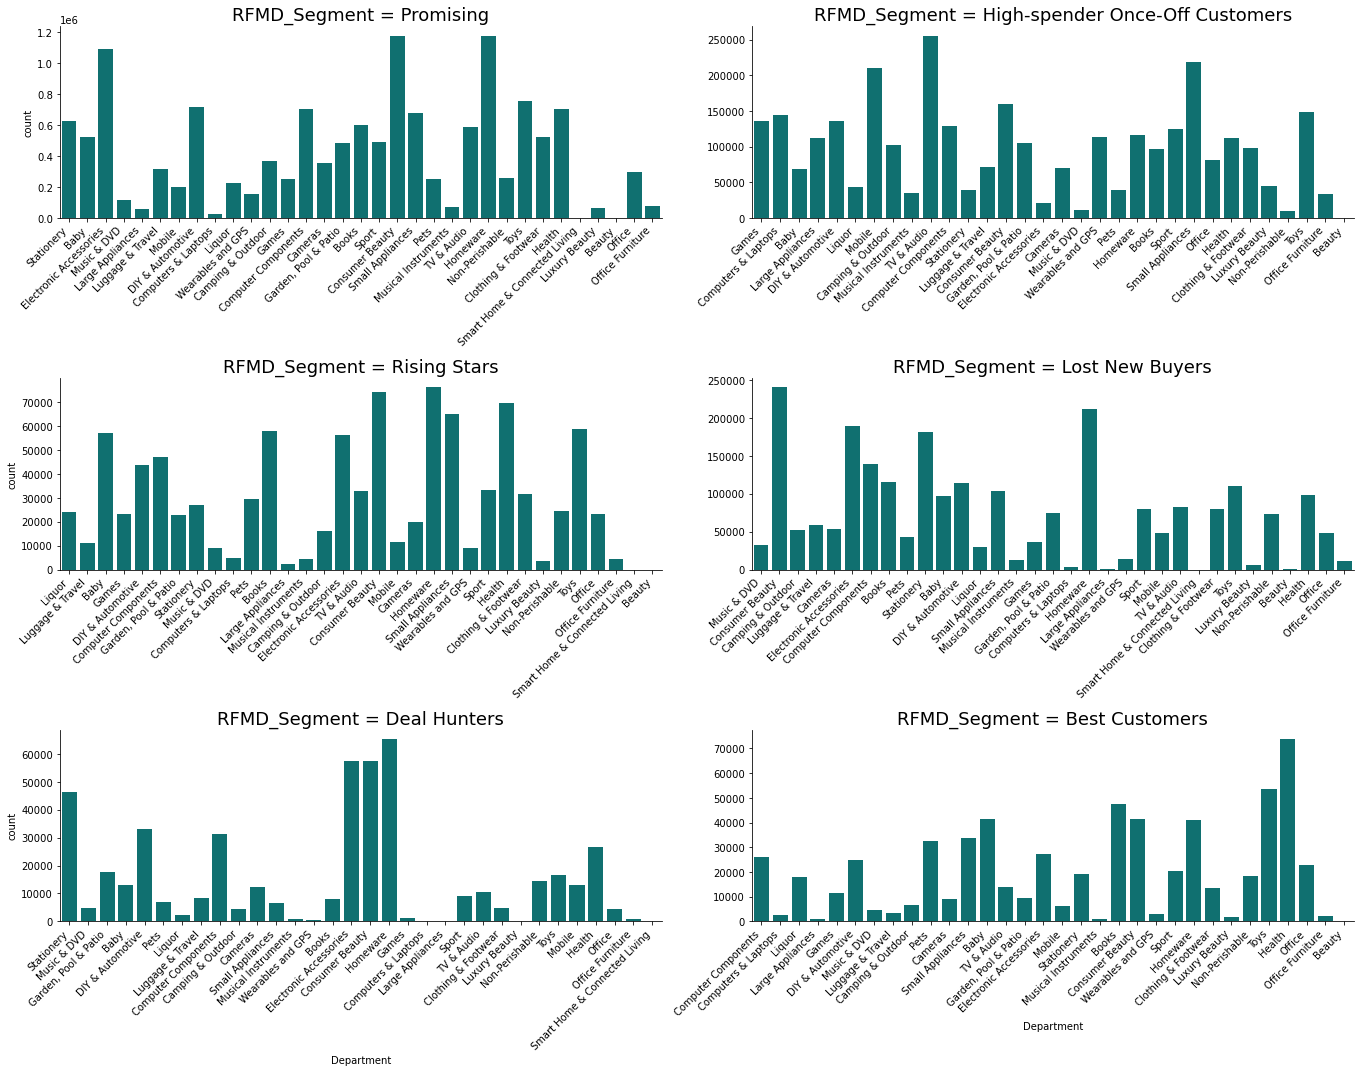

In [50]:
# Covid
g = sns.catplot(x="Department", col="RFMD_Segment",data=df_with_lvl1_binned[df_with_lvl1_binned['is_Covid']=='Covid'], kind="count",height=5,color='teal',
                aspect=1.9,sharex=False,sharey=False,col_wrap=2)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
g.set_titles(size=18)
g.tight_layout()

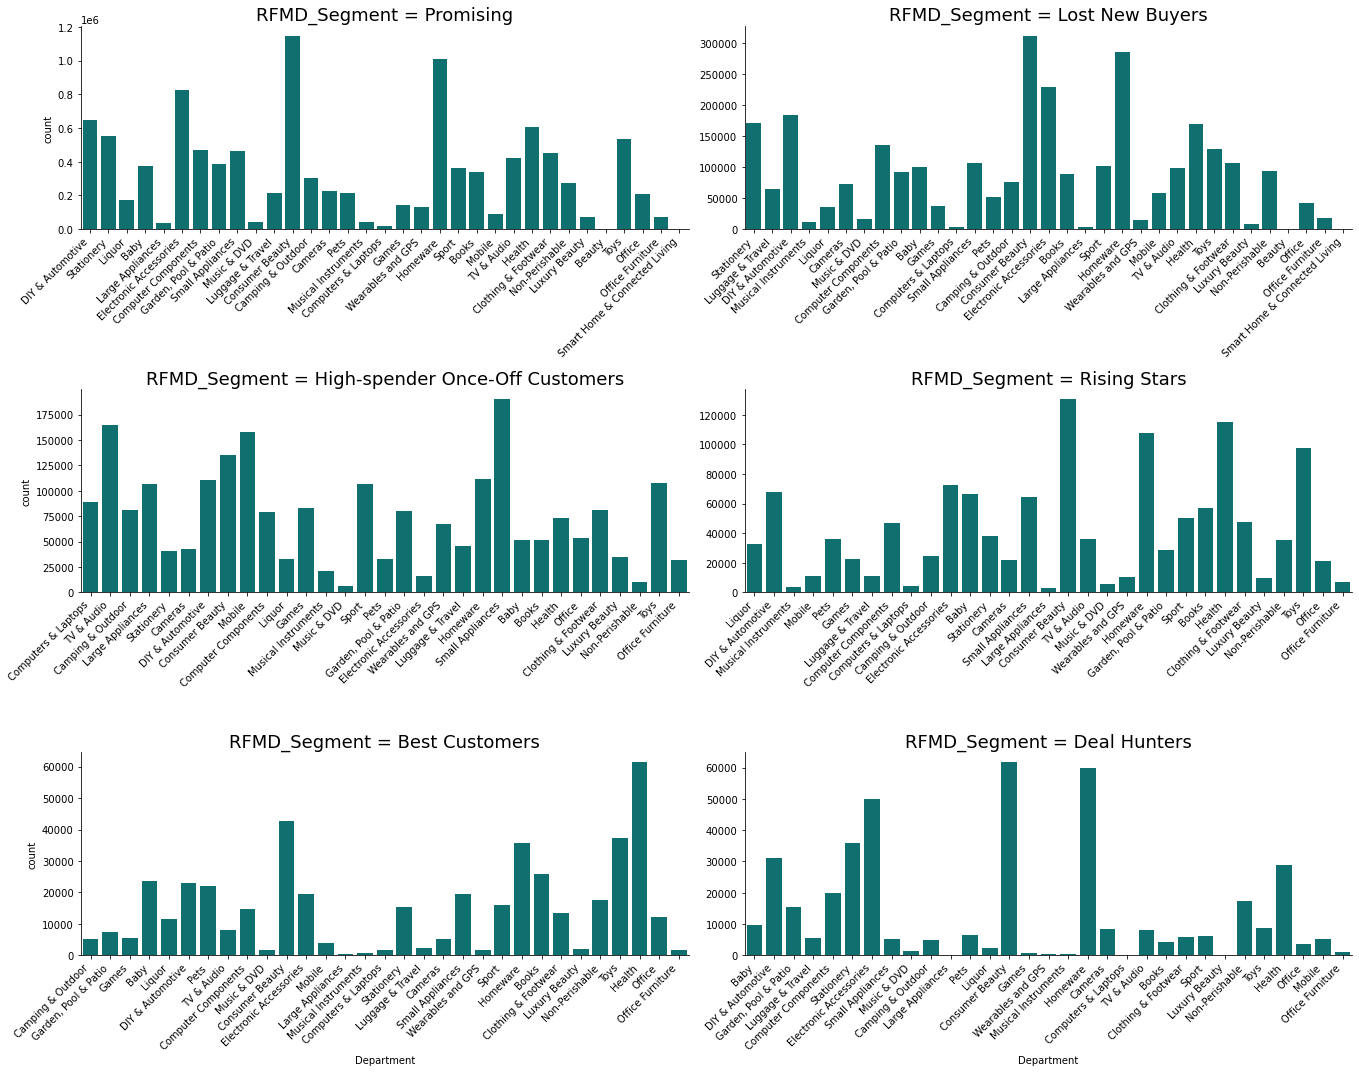

In [52]:
# After Covid
g = sns.catplot(x="Department", col="RFMD_Segment",data=df_with_lvl1_binned[df_with_lvl1_binned['is_Covid']=='After_Covid'], kind="count",height=5,color='teal',
                aspect=1.9,sharex=False,sharey=False,col_wrap=2)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
g.set_titles(size=18)
g.tight_layout()

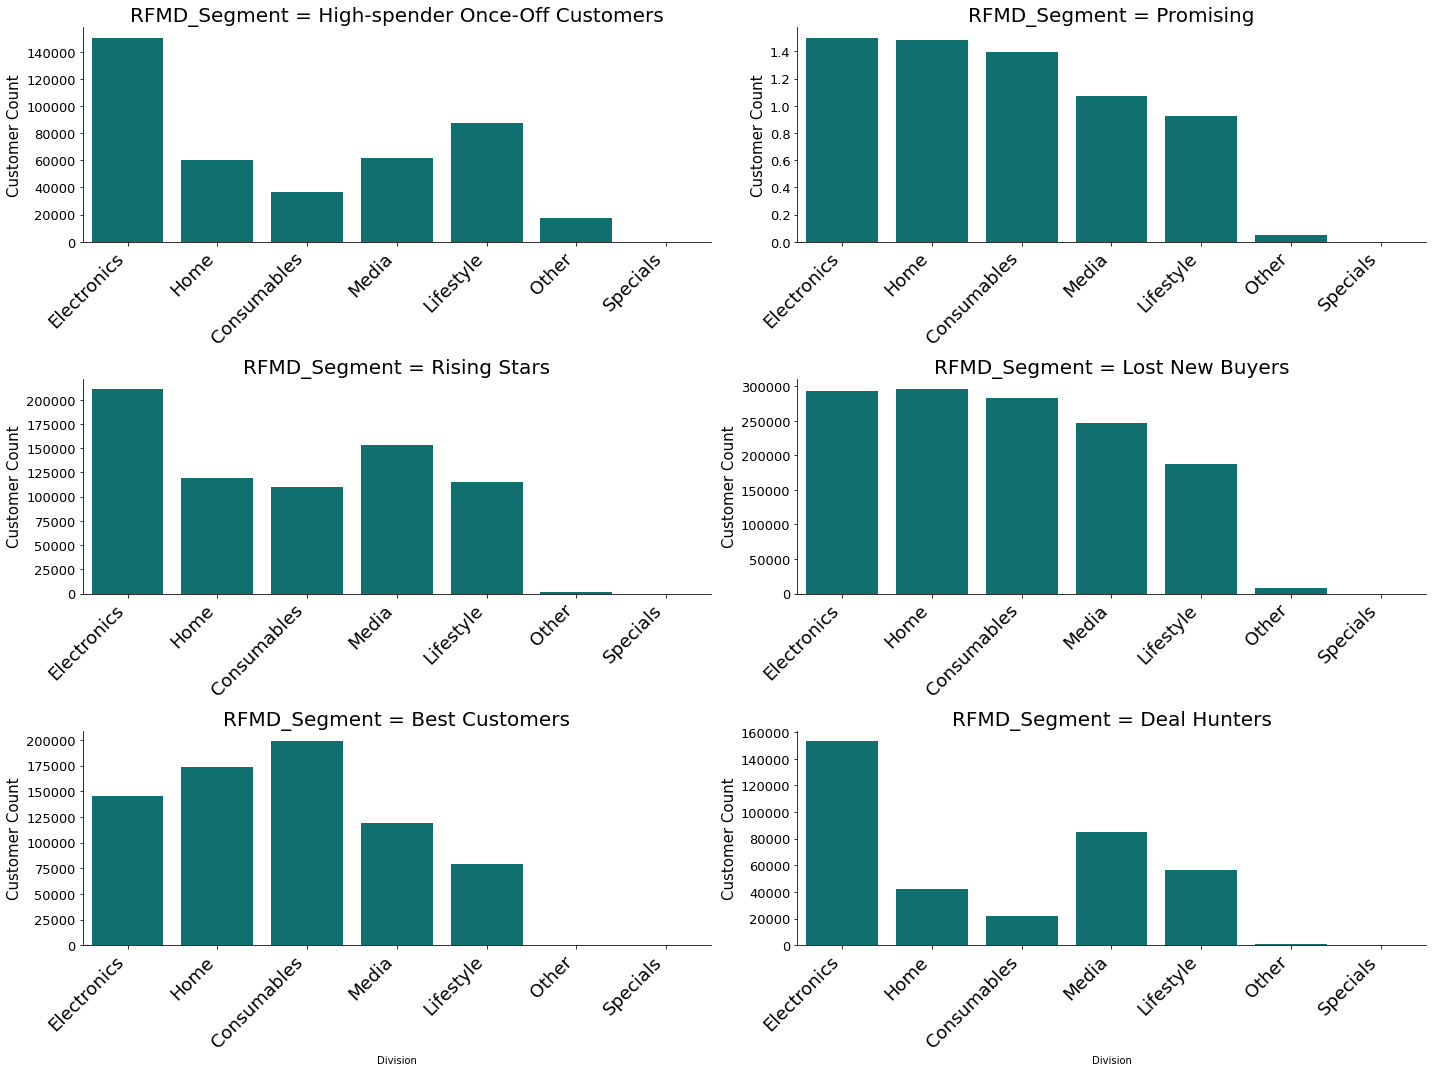

In [124]:
# Division - Covid Period
g = sns.catplot(x="Division", col="RFMD_Segment",data=df_no_lvl1_binned[df_no_lvl1_binned['is_Covid']=='Covid'], kind="count",height=5,color='teal',
                aspect=2,sharex=False,sharey=False,col_wrap=2,order=df_no_lvl1_binned['Division'].value_counts(ascending=False).index)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right",fontsize=18)
    axes.set_yticklabels(axes.get_yticklabels(), fontsize=13)
    axes.set_ylabel('Customer Count',fontsize=15)
g.set_titles(size=20)
g.tight_layout()

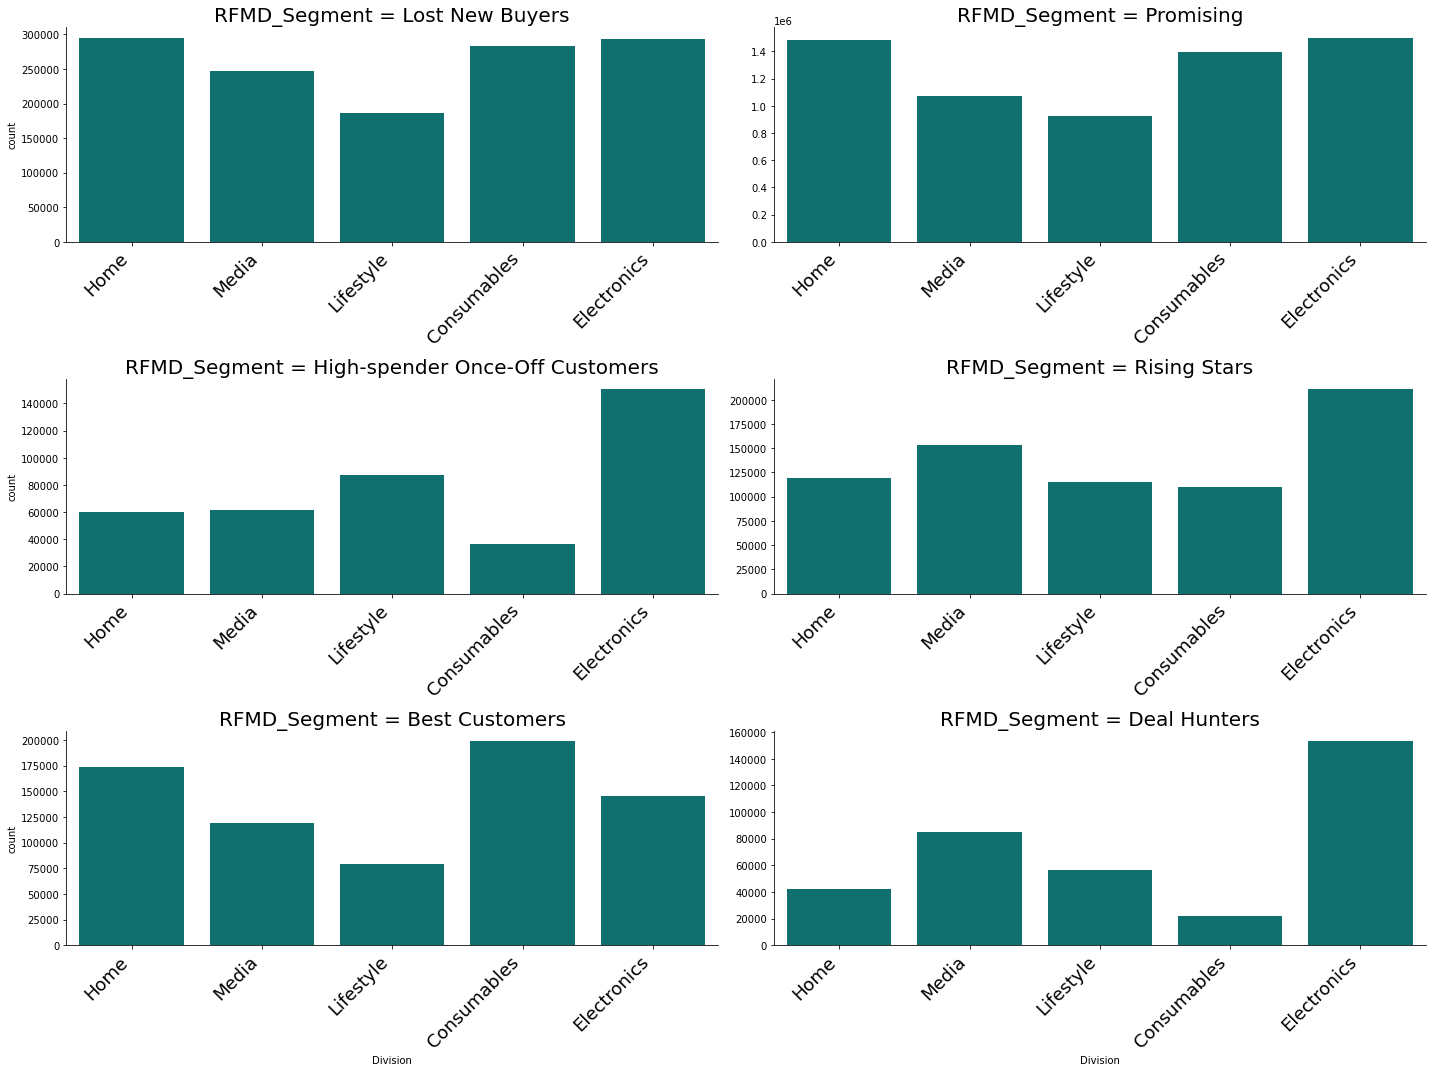

In [59]:
# Covid - Divisions
g = sns.catplot(x="Division", col="RFMD_Segment",data=df_no_lvl1_binned[df_no_lvl1_binned['is_Covid']=='Covid'], kind="count",height=5,color='teal',
                aspect=2,sharex=False,sharey=False,col_wrap=2)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right",fontsize=18)
g.set_titles(size=20)
g.tight_layout()

In [ ]:
# redefine covid and after covid

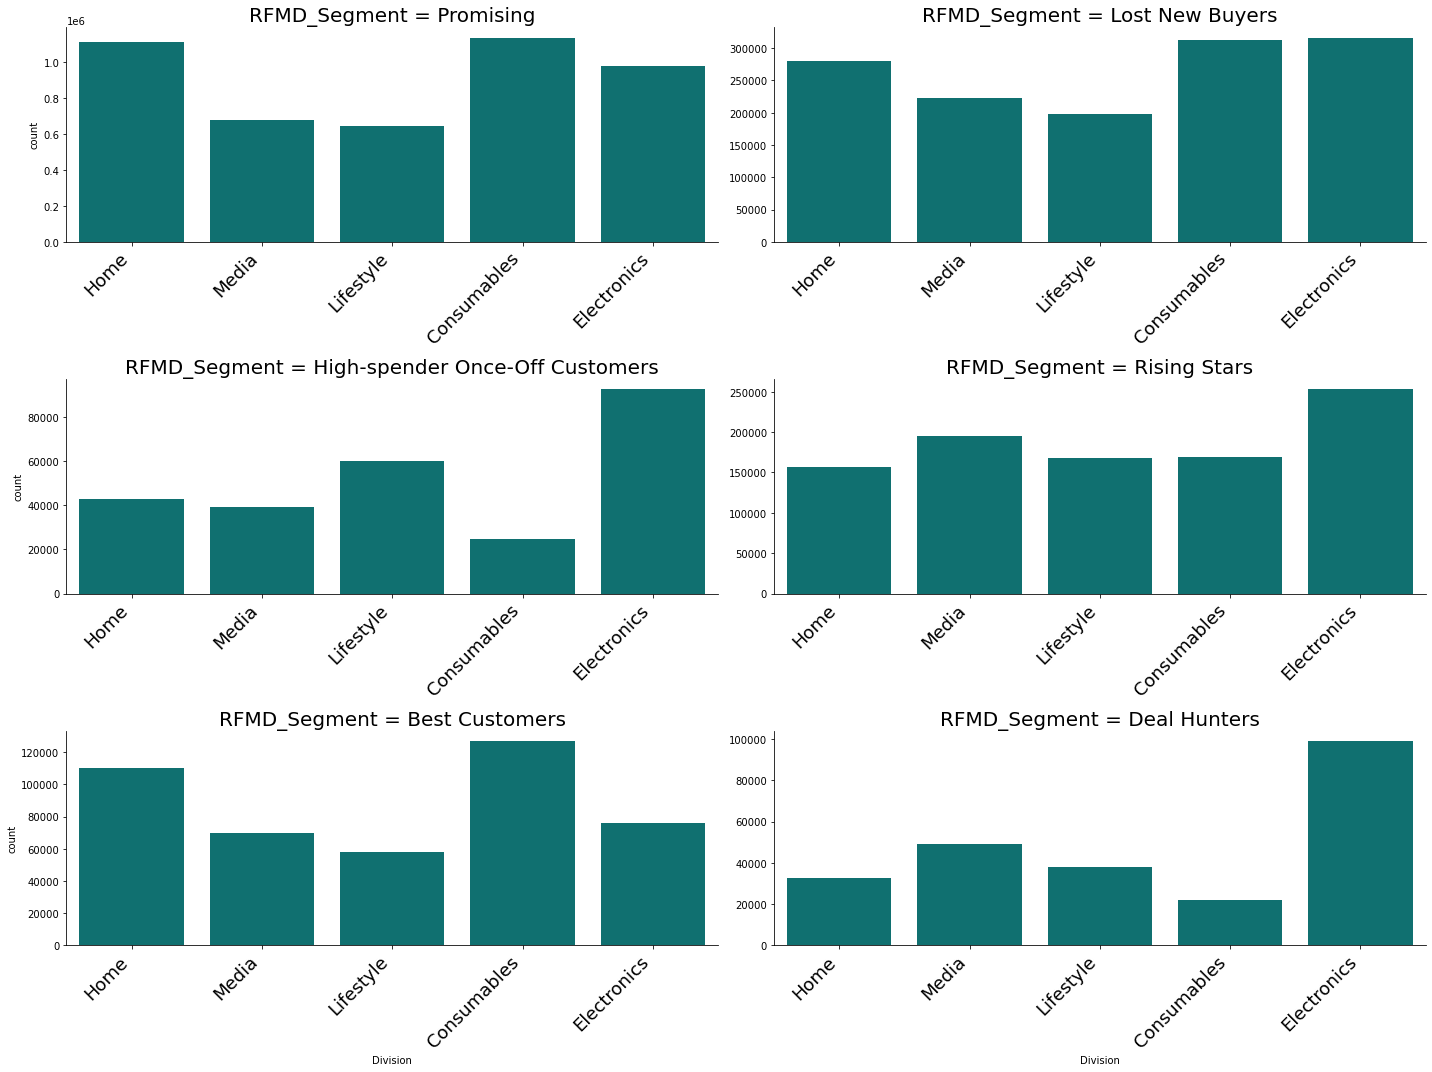

In [58]:
# Divisions- After Covid
g = sns.catplot(x="Division", col="RFMD_Segment",data=df_no_lvl1_binned[df_no_lvl1_binned['is_Covid']=='After_Covid'], kind="count",height=5,color='teal',
                aspect=2,sharex=False,sharey=False,col_wrap=2)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right",fontsize=18)
g.set_titles(size=20)
g.tight_layout()

- Best Customers (most recent, most frequent, high spenders and assocation) - this group of customers mostly purchase products from Health, Consumer Beauty, Homeware, Pets, Baby and Electronic Accessories. These customers are most likely to engage a campain or make a repurchase on products from these departments. 
## ---------------------------------------------------------------------------------------------------------------------------------
- Deal Hunters (most recent, most frequent, low spenders) - the top purchases of these customers are products from Consumer Beauty, Stationery, Health and Electronic Accessories. To keep these customers engaged and buying more often, they should be targeted with more/similar products from these departments.
## --------------------------------------------------------------------------------------------------------------------------------
- High-Spender-Once-Off (transacted only once but high spenders) - when these customers transact with us they only come to buy high AISP items, this can be seen from their top purchases being products from TV&Audio, Mobile, Computers/Laptops, Homeware and Small Appliances department.
## --------------------------------------------------------------------------------------------------------------------------------
- Churned-Dormant-Best-Customers (transacted more often, spent high but long time ago) - their top purchases were mostly products from Homeware, Consumer Beauty, Health, Electronic accessories and Toys department. These customers have a very similar purchasing behaviour and product preferences with the Best customers group. They could have been in the same group as our Best customers if they never stopped buying from us. It would be worthwile to have a strategy to re-activate these customers.

##### Divisions

In [62]:
df_grouped_covid = df_no_lvl1_binned[df_no_lvl1_binned['is_Covid']=='Covid'].groupby(['Division','RFMD_Segment']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean'
}).reset_index()

In [64]:
df_grouped_aft_covid = df_no_lvl1_binned[df_no_lvl1_binned['is_Covid']=='After_Covid'].groupby(['Division','RFMD_Segment']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean'
}).reset_index()

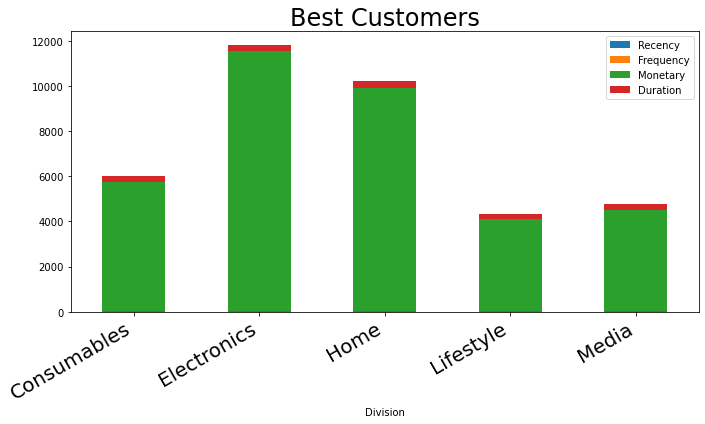

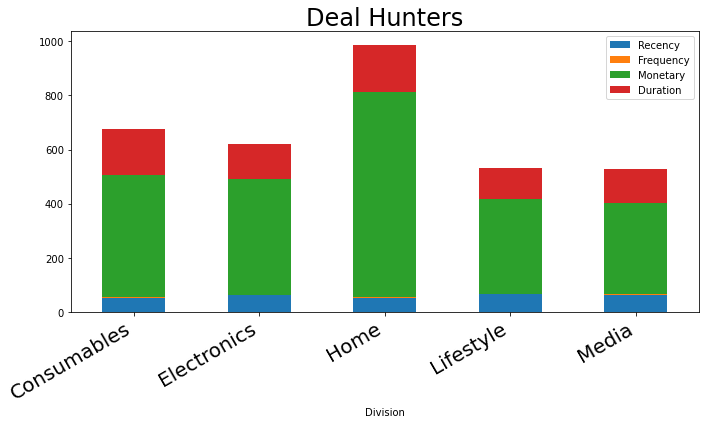

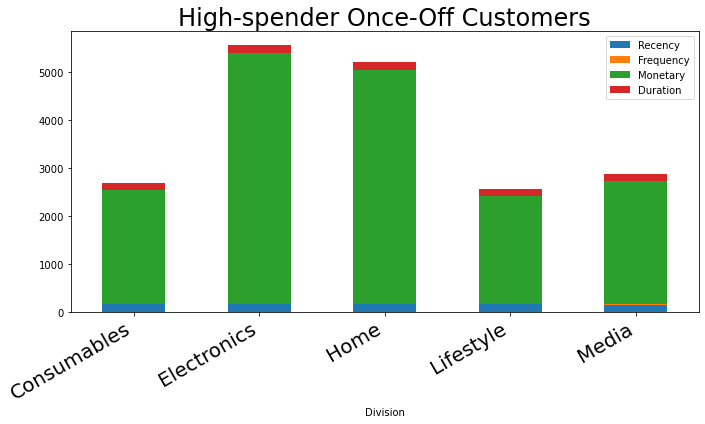

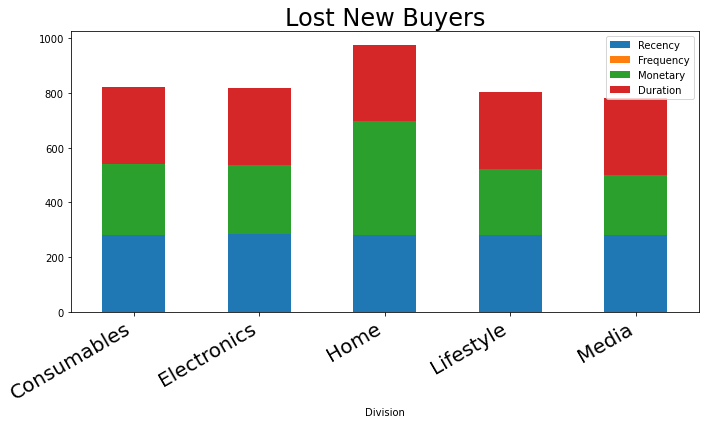

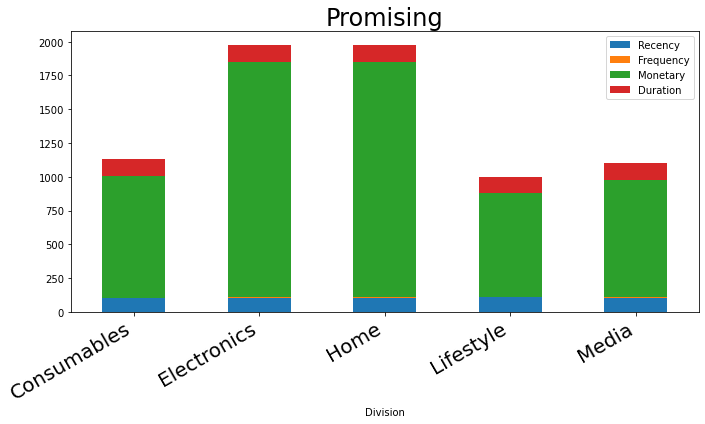

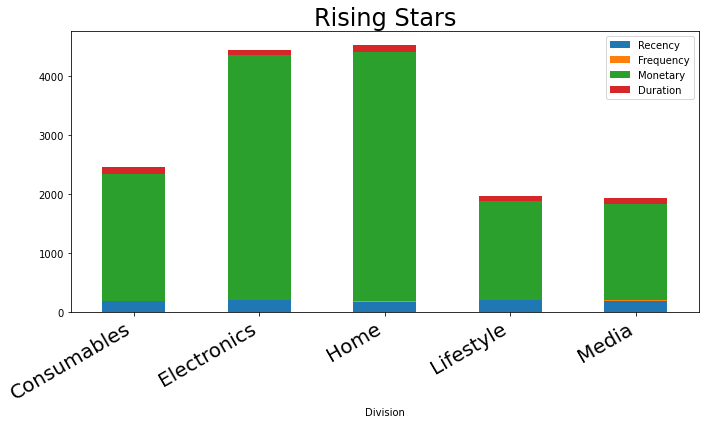

In [80]:
#covid
#df_g = df_grouped_covid
#df_g.set_index(['Division'], inplace=True)
for RFMD_Segment in df_g.RFMD_Segment.unique():
    #ax = plt.subplots(3, 2)
    ax = df_g[df_g.RFMD_Segment==RFMD_Segment].plot.bar(stacked=True,figsize=(10,6))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right",fontsize=20)
    ax.legend(loc='upper right')
    ax.set_title(RFMD_Segment,fontsize=24)
    plt.tight_layout()

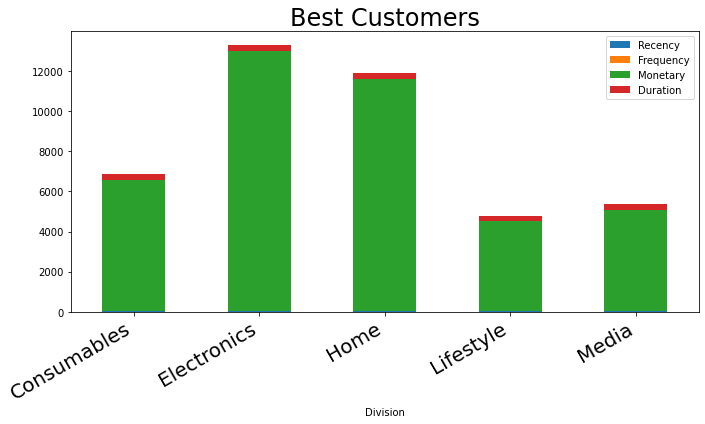

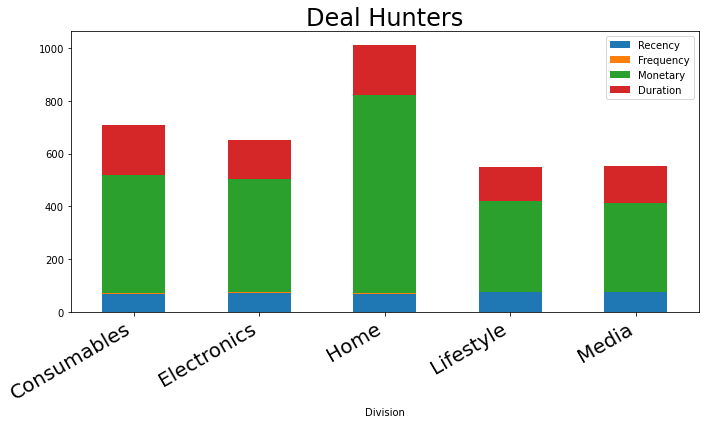

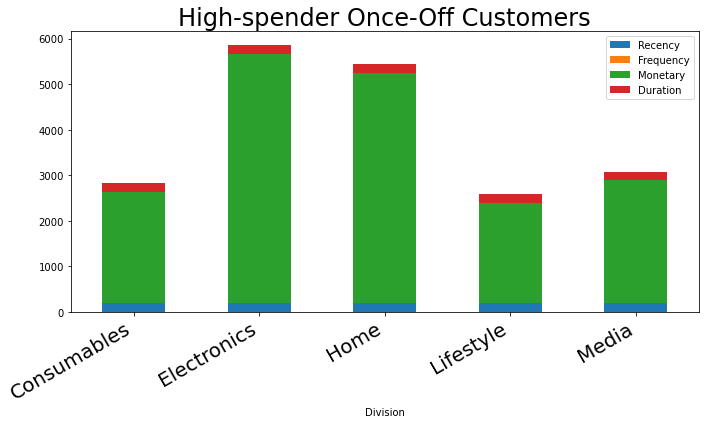

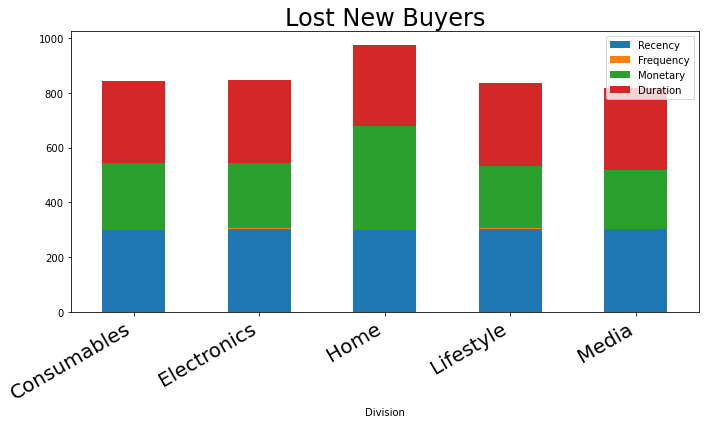

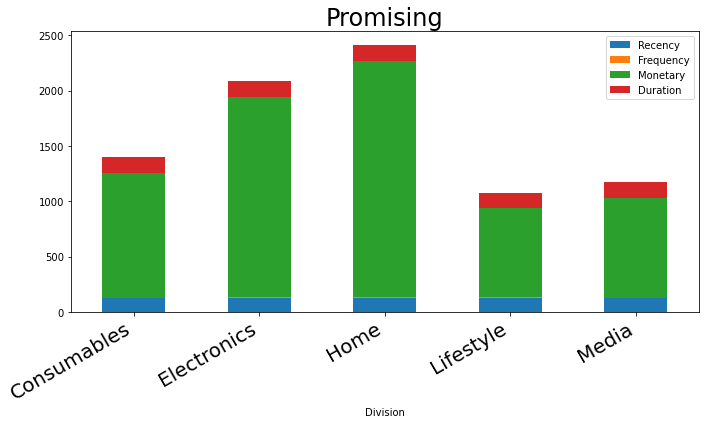

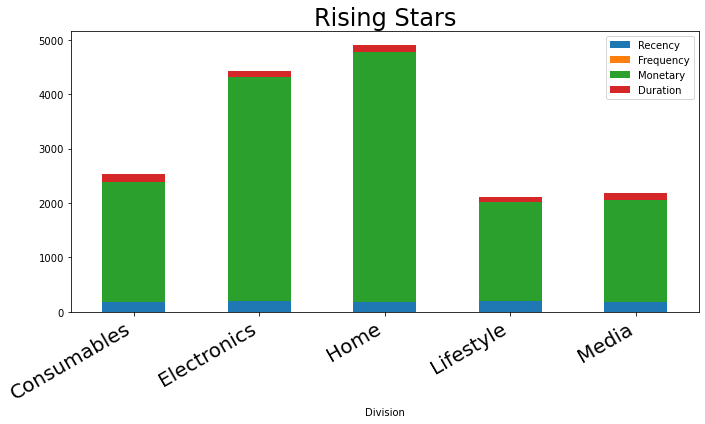

In [83]:
#After covid
#df_g = df_grouped_aft_covid
#df_g.set_index(['Division'], inplace=True)
for RFMD_Segment in df_g.RFMD_Segment.unique():
    #ax = plt.subplots(3, 2)
    ax = df_g[df_g.RFMD_Segment==RFMD_Segment].plot.bar(stacked=True,figsize=(10,6))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right",fontsize=20)
    ax.legend(loc='upper right')
    ax.set_title(RFMD_Segment,fontsize=24)
    plt.tight_layout()

#### Departments

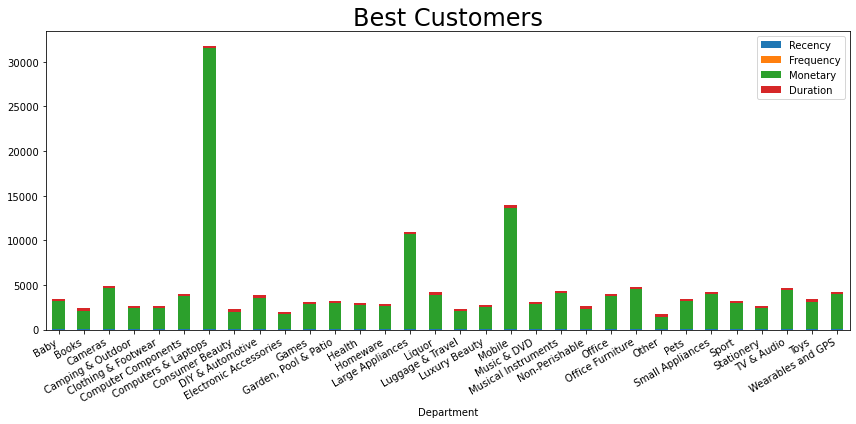

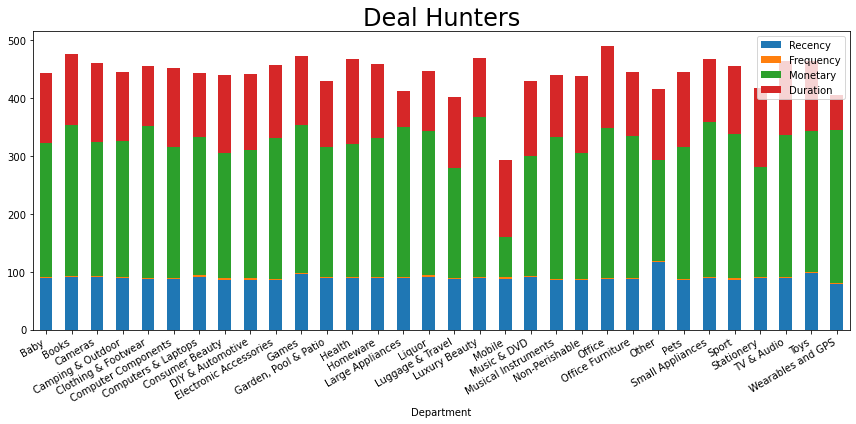

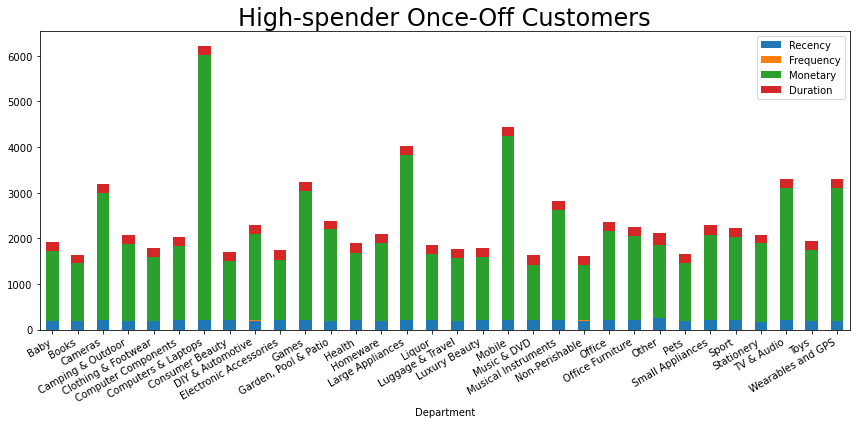

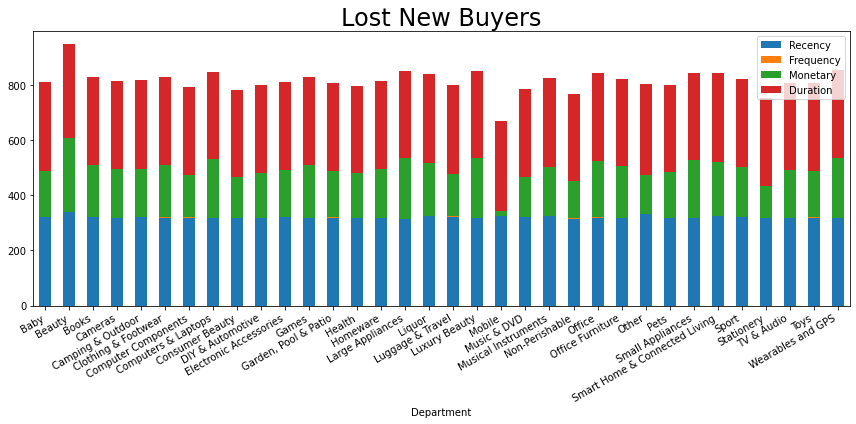

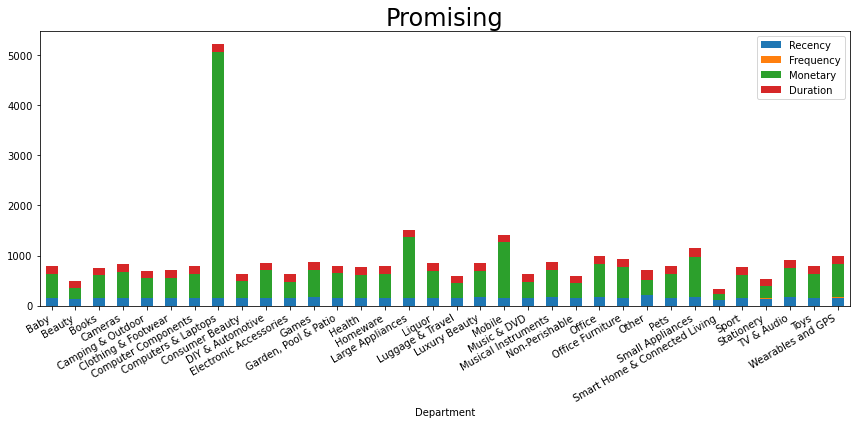

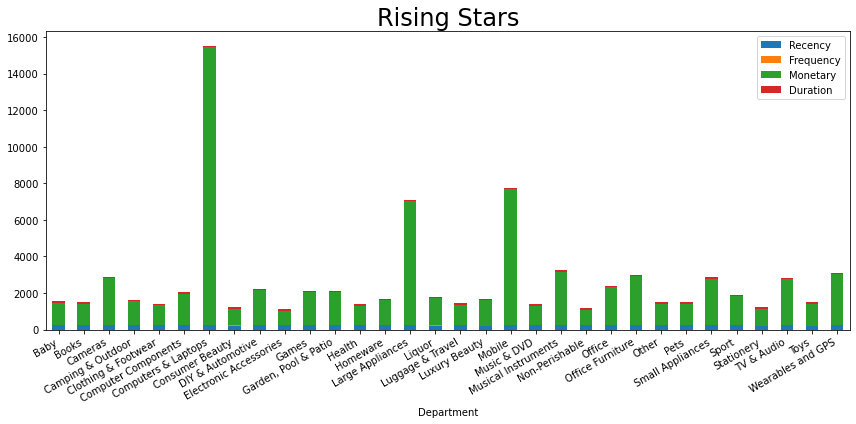

In [90]:
#after covid
df_g2 = df_grouped3
df_g2.set_index(['Department'], inplace=True)
for RFM_Segment in df_g2.RFM_Segment.unique():
    #ax = plt.subplots(3, 2)
    ax = df_g2[df_g2.RFM_Segment==RFM_Segment].plot.bar(stacked=True,figsize=(12,6))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    ax.legend(loc='upper right')
    ax.set_title(RFM_Segment,fontsize=24)
    plt.tight_layout()

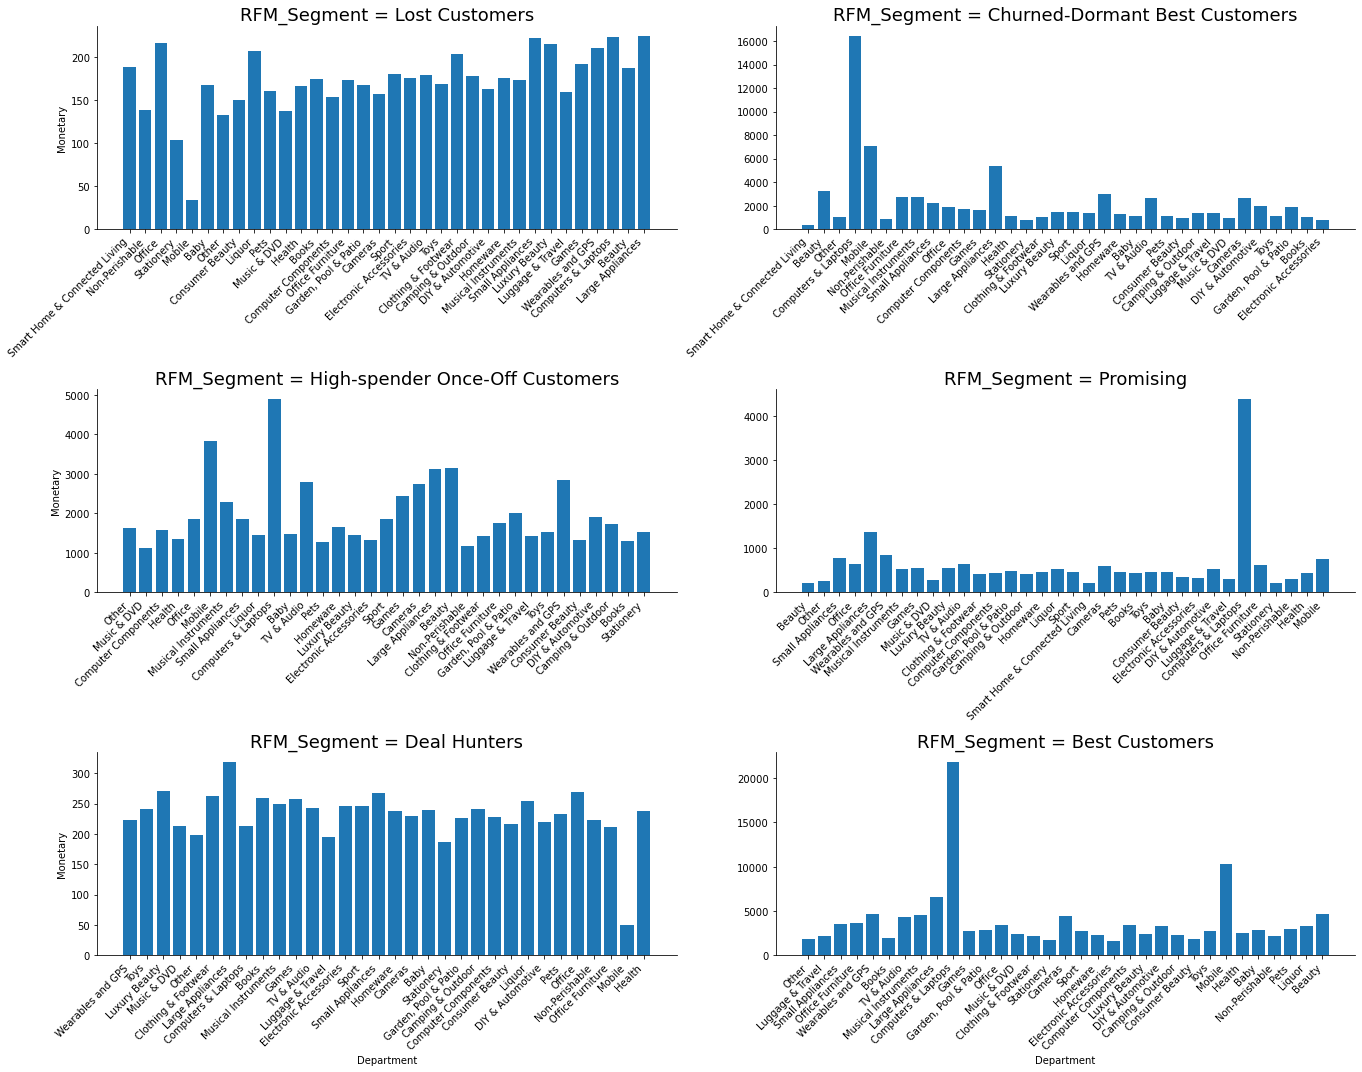

In [276]:
# use concat to combine more than two DataFrames

g = sns.FacetGrid(data=df_grouped2, col='RFM_Segment',height=5,
                aspect=1.9,sharex=False,sharey=False,col_wrap=2)
g = g.map(plt.bar, 'Department', 'Monetary')
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
g.set_titles(size=18)
g.tight_layout()

### Observations
- Best customers - Their frequency is almost the same across all categories but highest on Mobile. Recency is low across all categories (less than 2 months). They spend a lot on Computers/Laptops, Large Appliances and Mobile. Upsell products from these categories, they're highly likely to generate even more revenue.
######  -----------------------------------------------------------------------------------------------------------------------
- Deal Hunters - Frequency is the same on all categories but highest on Mobile, recenct is low. Spending is low and similar across all categories. These customers are very engaged with our products but spend low. Seeing that they're active, campaigns to increase their spend levels would be worthwile.
######  -----------------------------------------------------------------------------------------------------------------------
- Churned-Dormant-Best Customers - Since they've churned/dormant their recency is very high across all categories, but they were frequently buying products from Mobile, Music&DVD, Non-Perishable, Health, Baby and Pets. They were also spending a lot on these categories. These are valuable customers who stopped transacting a long time ago. While it may be challenging to re-engage them, the high value of them makes it worthwhile trying.
######  -----------------------------------------------------------------------------------------------------------------------
- Promising - frequency and spending similar acoss all categories.
- High-Spender-Once-Off - Since these are once off purchasers, they spend on high AISP items, Mobiles, Computers/Laptops, TV, Large and Small Appliances.
######  -----------------------------------------------------------------------------------------------------------------------
- Lost Customers - low spend and low frequency across all categories

# BetaGeoFitter for Propensity


BG/NBD - Beta Geometric/Negative Binomial Distribution.

This is the probabilistic model for predicting the customer lifetime value and future transactions of each customer.


###### Assumptions of the BG/NBD for predicting the transaction of a customer:

1. When a customer is active, number of transactions in a time t is described by Poisson distribution with rate lambda.


2. Customers may become inactive after any transaction with probability p and their 'dropout' point is distributed between purchases with Geometric distribution. 


The model fits the distribution to each customer's purchase history and learn the distribution parameters and then use them to predict future transactions of a customer.

The python package 'lifetimes' has all the major models and utility functions that are needed for CLV calculations, to predict  customer churn, purchases etc.

In [9]:
df_pred = df_no_lvl1_binned[df_no_lvl1_binned['is_Covid']=='After_Covid']

In [70]:
df_pred_v2 = df_with_lvl1_binned[df_with_lvl1_binned['is_Covid']=='After_Covid']

In [51]:
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.fitters.modified_beta_geo_fitter import ModifiedBetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_expected_repeat_purchases
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

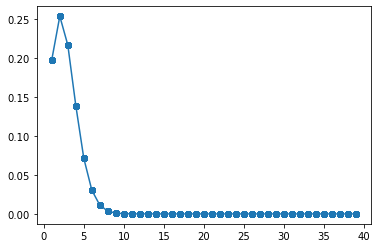

In [89]:
freq_values = df_pred[df_pred['Frequency']<40]
freq_values = freq_values['Frequency'].values
freq_values.sort()

mean = freq_values.mean() 
ps = stats.poisson.pmf(freq_values,mean)
plt.plot(n,ps, 'o-')
plt.show()

In [11]:
#df_pred['Recency'] = np.where((df_pred['Recency']>df_pred['Duration']),df_pred['Duration'],df_pred['Recency'])
df_pred['Monetary'] = round(np.floor(pd.to_numeric(df_pred['Monetary'], errors='coerce')).astype('float64'),0)
df_pred['Recency'] = round(np.floor(pd.to_numeric(df_pred['Recency'], errors='coerce')).astype('float64'),0)
df_pred['Frequency'] = round(np.floor(pd.to_numeric(df_pred['Frequency'], errors='coerce')).astype('float64'),0)
df_pred['Duration'] = round(np.floor(pd.to_numeric(df_pred['Duration'], errors='coerce')).astype('float64'),0)

In [73]:
#df_pred_v2['Recency'] = np.where((df_pred_v2['Recency']>df_pred_v2['Duration']),df_pred_v2['Duration'],df_pred_v2['Recency'])
df_pred_v2['Monetary'] = round(np.floor(pd.to_numeric(df_pred_v2['Monetary'], errors='coerce')).astype('float64'),0)
df_pred_v2['Recency'] = round(np.floor(pd.to_numeric(df_pred_v2['Recency'], errors='coerce')).astype('float64'),0)
df_pred_v2['Frequency'] = round(np.floor(pd.to_numeric(df_pred_v2['Frequency'], errors='coerce')).astype('float64'),0)
df_pred_v2['Duration'] = round(np.floor(pd.to_numeric(df_pred_v2['Duration'], errors='coerce')).astype('float64'),0)

In [12]:
start_time = time.time()
bgf = BetaGeoFitter(penalizer_coef = 0.1)
bgf.fit(df_pred['Frequency'],df_pred['Recency'],df_pred['Duration'])
print(bgf)
bgf.summary

print("--- %s seconds ---" % (time.time() - start_time))

<lifetimes.BetaGeoFitter: fitted with 7767868 subjects, a: 0.19, alpha: 15.47, b: 0.69, r: 0.60>
--- 172.50646901130676 seconds ---


In [13]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.598927,0.000282,0.598374,0.599479
alpha,15.465935,0.011980,15.442453,15.489417
a,0.190991,0.000210,0.190578,0.191403
b,0.686785,0.000524,0.685759,0.687812


- r, apha - difference in transaction rate between customers
- r,alpha,a,b are estimated using the maximum likelihood method

### Predicting number of purchases in the next t days

In [467]:
bgf.conditional_expected_number_of_purchases_up_to_time(150,150,30,300)

1.091881279277752e-122

In [14]:
# t = 60 (means in the next 60 days)
t = 60
df_pred['predicted_orders'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_pred['Frequency'], df_pred['Recency'], df_pred['Duration'])
df_pred.sort_values(by='predicted_orders', ascending=False).head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders
12879044,7413954,FY22,Media,89.0,999.0,964429.0,89.0,After_Covid,1,4,4,2,1442,11,Rising Stars,548.025161
5875597,7413849,FY22,Media,152.0,709.0,813595.0,152.0,After_Covid,1,4,4,2,1442,11,Rising Stars,246.503518
2399875,7413996,FY22,Media,182.0,793.0,773123.0,182.0,After_Covid,2,4,4,3,2443,13,Rising Stars,234.802452
520685,7414017,FY22,Media,90.0,422.0,340745.0,90.0,After_Covid,1,4,4,2,1442,11,Rising Stars,229.508333
12993530,7413841,FY22,Media,119.0,471.0,438089.0,119.0,After_Covid,1,4,4,2,1442,11,Rising Stars,202.657679


In [66]:
pd.set_option('display.float_format', lambda s: '%.4f' % s)
df_pred[df_pred['customer_id']==4394777].sort_values(by='predicted_orders', ascending=False).head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy
6830159,4394777,FY22,Electronics,193.0000,117.0000,3635.0000,200.0000,After_Covid,2,4,4,3,2443,13,Rising Stars,29.6005,0.9263,3642.7998,0.0468
5445188,4394777,FY22,Home,22.0000,2.0000,712.0000,22.0000,After_Covid,1,2,2,1,1221,6,Promising,3.3034,0.8983,815.3348,0.5149
7900681,4394777,FY22,Lifestyle,149.0000,5.0000,3623.0000,149.0000,After_Covid,2,4,4,3,2443,13,Rising Stars,1.8960,0.9608,3814.0677,0.4158
9987881,4394777,FY22,Consumables,63.0000,2.0000,435.0000,63.0000,After_Covid,1,2,2,1,1221,6,Promising,1.6624,0.8983,498.8246,0.5596


For customer_id = 4394777, the model predicts that this customer will make 29 orders in Electronics in the next 60 days. To calculate this, the model takes the customer's Duration (200 days) and Frequency (117), meaning in Electronics this customer made 117 orders in 200 days, which means the customer was making 117/200=0.0.585 orders a day. Therefore, at this rate, in the next 60 days they're predicted to make 0.0.585*60 = 35 orders (close to the predicted value).

In [55]:
start_time = time.time()

par = ParetoNBDFitter(penalizer_coef=0.01) 
par.fit(df_pred['Frequency'],df_pred['Recency'],df_pred['Duration'])
print(par) 

print("--- %s seconds ---" % (time.time() - start_time))

<lifetimes.ParetoNBDFitter: fitted with 3792097 subjects, alpha: 215.63, beta: 414.63, r: 1.23, s: 1.14>
--- 48849.62708067894 seconds ---


In [65]:
# Probability to make an order in the next 60 days
t = 60
n = 1
df_pred['prob_to_buy'] = par.conditional_probability_of_n_purchases_up_to_time(n,t, df_pred['Frequency'], df_pred['Recency'], df_pred['Duration'])
df_pred.sort_values(by='prob_to_buy', ascending=False).head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy
6653526,160654,FY22,Consumables,30.0000,134.0000,125432.0000,362.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,125666.1578,1.0000
13085511,982700,FY22,Media,37.0000,81.0000,54848.0000,323.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,55017.6161,1.0000
6625377,196021,FY22,Consumables,34.0000,86.0000,47761.0000,357.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,47900.0923,1.0000
278392,7262172,FY22,Home,32.0000,77.0000,89473.0000,361.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,89764.0880,1.0000
14856960,3095871,FY22,Media,32.0000,59.0000,55794.0000,348.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,56031.1517,1.0000


### Customer Probability Active

In [16]:
df_pred['prob_active'] = bgf.conditional_probability_alive(df_pred['Frequency'], df_pred['Recency'],df_pred['Duration'])
df_pred.sort_values(by='prob_active', ascending=False).head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active
12879044,7413954,FY22,Media,89.0000,999.0000,964429.0000,89.0000,After_Covid,1,4,4,2,1442,11,Rising Stars,548.0252,0.9998
2399875,7413996,FY22,Media,182.0000,793.0000,773123.0000,182.0000,After_Covid,2,4,4,3,2443,13,Rising Stars,234.8025,0.9998
5875597,7413849,FY22,Media,152.0000,709.0000,813595.0000,152.0000,After_Covid,1,4,4,2,1442,11,Rising Stars,246.5035,0.9997
16618482,7413926,FY22,Media,182.0000,540.0000,719166.0000,182.0000,After_Covid,2,4,4,3,2443,13,Rising Stars,159.9275,0.9996
4219596,7413981,FY22,Media,167.0000,498.0000,697297.0000,167.0000,After_Covid,1,4,4,3,1443,12,Rising Stars,159.3098,0.9996


<AxesSubplot:title={'center':'Probability Customer is Active, \nby Frequency and Duration of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Duration">

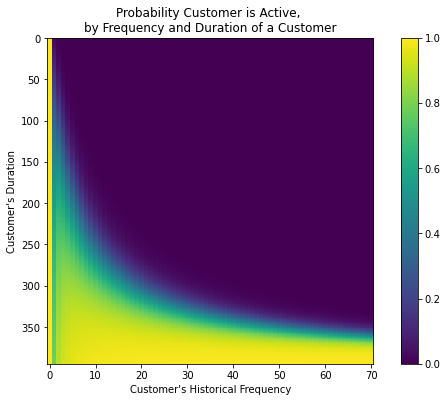

In [340]:
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf,max_frequency=70,xlabel="Customer's Historical Frequency",ylabel="Customer's Duration",
                             title='Probability Customer is Active, \nby Frequency and Duration of a Customer')

### Gamma-Gamma - Modelling Monetary value

- The BG/NBD model can only predict customer's future purchases and whether they're active/inactive.
- To add the monetary aspect of the customer purchases, a Gamma-Gamma model is used to predict how much each customer will spend.

#### To predict the expected average monetary for each purchase we use:

- model.conditional_expected_average_profit(): This method computes expected average monetary per transaction/purchase of customers.

In [17]:
df_pred = df_pred[(df_pred['Frequency'] > 1) & (df_pred['Monetary'] > 0)]
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(df_pred['Frequency'], df_pred['Monetary'])
print(ggf)
ggf.summary

<lifetimes.GammaGammaFitter: fitted with 3792097 subjects, p: 3.18, q: 0.21, v: 3.11>


,coef,se(coef),lower 95% bound,upper 95% bound
p,3.1781,0.0026,3.1729,3.1833
q,0.2066,0.0001,0.2063,0.2068
v,3.1117,0.0027,3.1065,3.1169


In [18]:
df_pred['predicted_gmv'] = ggf.conditional_expected_average_profit(df_pred['Frequency'], df_pred['Monetary'])
df_pred.sort_values(by='predicted_gmv', ascending=False).head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv
5300125,2087904,FY22,Electronics,38.0000,115.0000,8221967.0000,328.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,8239855.5231
3239998,3329865,FY22,Electronics,35.0000,14.0000,2207508.0000,338.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,2247589.4506
10435274,5691481,FY22,Electronics,30.0000,363.0000,1674728.0000,364.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,1675880.6349
6915054,2736175,FY22,Electronics,38.0000,93.0000,1612688.0000,341.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.0000,0.0000,1617029.0050
5952093,9214031,FY22,Media,30.0000,1010.0000,1527884.0000,68.0000,After_Covid,4,4,4,1,4441,13,Promising,0.0000,0.0000,1528261.7739


In [122]:
# split data to train and test set (Train FY20-FY21, Test-FY22)
df_no_lvl1_binned['Date']  = np.where((df_no_lvl1_binned['is_Covid']=='Covid'),(pd.date_range(start='2019-4-1',end='2021-03-31',periods=len(df_no_lvl1_binned))),
                           (pd.date_range(start='2021-4-1',end='2022-4-1',periods=len(df_no_lvl1_binned))))

In [125]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df_no_lvl1_binned, 'customer_id','Date',
                                calibration_period_end='2021-03-31',
                                        observation_period_end='2022-4-1',
                                                  monetary_value_col = 'Monetary')
summary_cal_holdout.head()

             frequency_cal  recency_cal    T_cal  monetary_value_cal  \
customer_id                                                            
2                   1.0000     491.0000 563.0000            430.4300   
5                   3.0000     684.0000 713.0000            889.5633   
7                   1.0000     587.0000 659.0000            955.6500   
8                   2.0000     257.0000 677.0000           2007.8250   
10                  8.0000     709.0000 730.0000           2071.6325   

             frequency_holdout  monetary_value_holdout  duration_holdout  
customer_id                                                               
2                       3.0000               5977.6800          366.0000  
5                       1.0000                781.7400          366.0000  
7                       1.0000               1115.6500          366.0000  
8                       4.0000               8801.5225          366.0000  
10                      4.0000              1

In [127]:
# Validate the model on the test set
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 3057399 subjects, a: 0.00, alpha: 170.65, b: 0.00, r: 0.73>

In [69]:
df_final_grouped = df_pred.groupby(['RFMD_Segment','Division']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'prob_active':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'mean',
    'prob_to_buy':'mean',
    'customer_id':'nunique'
}).reset_index() 

In [346]:
# Export to google sheets
file = 'C:/Users/mncedisi.mncwabe/Downloads/tal-production-data-4390ad039b75.json'
id = '167EkrlctUGDRw79at13bwJnwbZYo3hIORqXwzv3HJHY'
s_n = 'predictions'

def write_to_gsheet(service_file_path, spreadsheet_id, sheet_name, data_df):
    gc = pygsheets.authorize(service_file=service_file_path)
    sh = gc.open_by_key(spreadsheet_id)
    try:
        sh.add_worksheet(sheet_name)
    except:
        pass
    wks_write = sh.worksheet_by_title(sheet_name)
    wks_write.clear('A1',None,'*')
    wks_write.set_dataframe(data_df, (1,1), encoding='utf-8', fit=True)
    wks_write.frozen_rows = 1

write_to_gsheet(file, id, s_n, df_final_grouped)

## Model Validation

- To assess the performance of the model, the data is split into train (FY20-FY21) and test set (FY22).
- The actual purchases from the train set are compared to the model’s prediction for that set, which means comparing the customer's actual purchases during F20-FY21 to what the model predicted for that period.
- The model is then validated on "unseen" data which is FY22.

<Figure size 864x576 with 0 Axes>

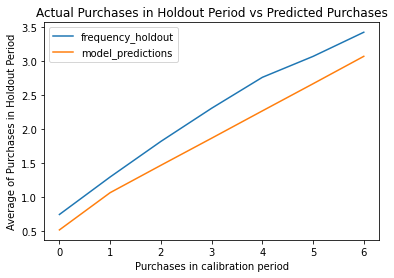

In [160]:
 """"Plot the predicted number of purchases in the train set to the actual purchases. 
"""

plt.figure(figsize=(12,8))
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show();

In [162]:
# RMSE
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(y_true = summary_cal_holdout["frequency_holdout"],
                          y_pred = summary_cal_holdout["frequency_cal"],
                          squared = False)
RMSE

2.0721061177471727

In [91]:
df_final_grouped_v2 = df_pred_v2[df_pred_v2['Division']=='Other'].groupby(['RFMD_Segment','Level1']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'prob_active':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'sum',
    'customer_id':'nunique'
}).reset_index() 
df_final_grouped_v2

,RFMD_Segment,Level1,Recency,Frequency,Monetary,Duration,prob_active,predicted_orders,predicted_gmv,customer_id
0,Best Customers,Other,78.4000,2.1333,1176.8667,245.6667,0.7991,6.9621,19786.2287,15
1,Deal Hunters,Other,85.3415,2.0732,124.7805,98.6829,0.9674,48.5864,5821.8025,41
2,Promising,Other,76.9875,2.1875,657.6667,86.1833,0.9706,321.8439,176548.2699,240
3,Rising Stars,Other,58.9066,2.1518,901.9650,58.9066,0.9759,402.9873,258855.7848,257


In [84]:
df_pred_v2.head()

,customer_id,FY,Division,Department,Level1,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv
10,5457,FY22,Home,DIY & Automotive,Home Security,83.0000,3.0000,5965.0000,83.0000,After_Covid,3,4,4,2,3442,13,Promising,1.4887,0.9854,6447.9317
46,4117175,FY22,Consumables,Liquor,Non-alcoholic,25.0000,2.0000,688.0000,25.0000,After_Covid,1,3,4,1,1341,9,Rising Stars,1.7546,0.9746,776.7091
98,1077119,FY22,Lifestyle,Camping & Outdoor,Camping Furniture,60.0000,2.0000,1524.0000,279.0000,After_Covid,4,4,4,4,4444,16,Best Customers,0.3393,0.6921,1718.2461
126,520135,FY22,Consumables,Baby,Mom & Baby Care,82.0000,2.0000,172.0000,219.0000,After_Covid,3,3,2,3,3323,11,Deal Hunters,0.5080,0.8582,195.5689
133,4095337,FY22,Lifestyle,Camping & Outdoor,Fishing equipment,9.0000,3.0000,1138.0000,9.0000,After_Covid,3,4,4,1,3441,12,Promising,2.8865,0.9854,1231.0941


In [87]:
df_other = df_pred_v2[df_pred_v2['Department']=='Other'][['RFMD_Segment','Recency','Frequency','Monetary','Duration',
                                                          'prob_active','predicted_gmv','predicted_orders']]

df_other.head()

,RFMD_Segment,Recency,Frequency,Monetary,Duration,prob_active,predicted_gmv,predicted_orders
307792,Rising Stars,25.0000,2.0000,311.0000,25.0000,0.3249,117.3721,0.8773
313133,Deal Hunters,5.0000,2.0000,113.0000,5.0000,0.3249,43.0403,1.1118
313354,Promising,240.0000,2.0000,165.0000,240.0000,0.3249,62.5618,0.2689
315443,Rising Stars,45.0000,2.0000,253.0000,45.0000,0.3249,95.5981,0.7246
315644,Deal Hunters,49.0000,2.0000,60.0000,49.0000,0.3249,23.1433,0.7002


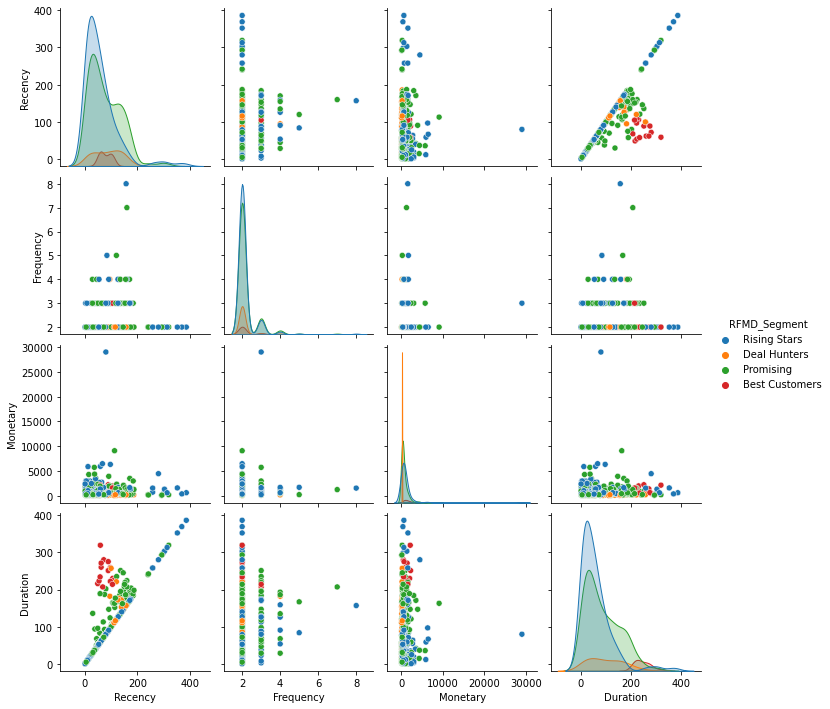

In [89]:
df_other1 = df_other[['RFMD_Segment','Recency','Frequency','Monetary','Duration']]
df_other2 = df_other[['RFMD_Segment','prob_active','predicted_gmv','predicted_orders']]
sns.pairplot(df_other1, hue = 'RFMD_Segment')

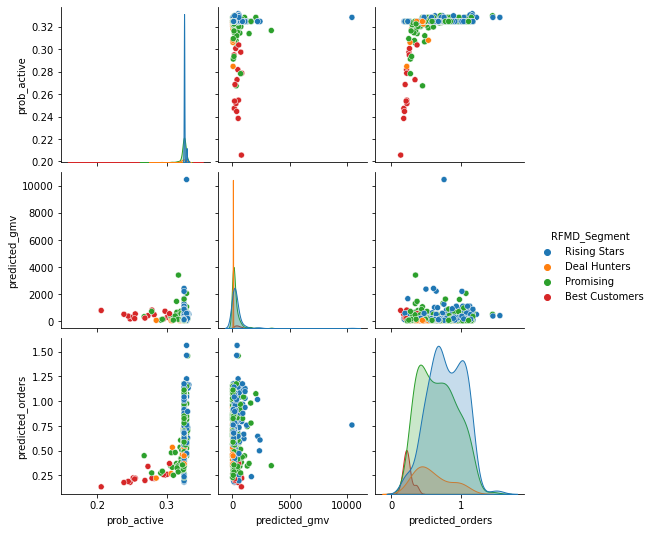

In [90]:
sns.pairplot(df_other2, hue = 'RFMD_Segment')

### Department predictions

In [128]:
df_pred_dep = df_with_lvl1_binned[df_with_lvl1_binned['is_Covid']=='After_Covid']

In [130]:
#df_pred_dep['Recency'] = np.where((df_pred_dep['Recency']>df_pred_dep['Duration']),df_pred_dep['Duration'],df_pred_dep['Recency'])
df_pred_dep['Monetary'] = round(np.floor(pd.to_numeric(df_pred_dep['Monetary'], errors='coerce')).astype('float64'),0)
df_pred_dep['Recency'] = round(np.floor(pd.to_numeric(df_pred_dep['Recency'], errors='coerce')).astype('float64'),0)
df_pred_dep['Frequency'] = round(np.floor(pd.to_numeric(df_pred_dep['Frequency'], errors='coerce')).astype('float64'),0)
df_pred_dep['Duration'] = round(np.floor(pd.to_numeric(df_pred_dep['Duration'], errors='coerce')).astype('float64'),0)

In [104]:
start_time = time.time()

par_dep = ParetoNBDFitter(penalizer_coef=0.01) 
par_dep.fit(df_pred_dep['Frequency'],df_pred_dep['Recency'],df_pred_dep['Duration'])
print(par_dep) 

print("--- %s seconds ---" % (time.time() - start_time))

<lifetimes.ParetoNBDFitter: fitted with 18243650 subjects, alpha: 464.22, beta: 423.67, r: 4.06, s: 0.00>
--- 6496.073402881622 seconds ---


In [495]:
t = 270
df_pred_dep['predicted_orders'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_pred_dep['Frequency'], df_pred_dep['Recency'], df_pred_dep['Duration'])
df_pred_dep.sort_values(by='predicted_orders', ascending=False).head()

,customer_id,FY,Division,Department,Level1,Recency,Frequency,Monetary,Duration,is_Covid,...,M,D,RFMD_Score,RFMD,RFMD_Segment,prob_to_buy,predicted_orders,predicted_gmv,Cust_Seq_Cat,prob_cat
14451778,7413954,FY22,Media,Books,Academic,89.0000,999.0000,963442.0000,89.0000,After_Covid,...,4,2,1442,11,Rising Stars,0.0007,2234.5396,963682.8387,20 -->22+ Purchaser,<10%
30400656,7413849,FY22,Media,Books,Academic,152.0000,703.0000,802153.0000,152.0000,After_Covid,...,4,3,2443,13,Rising Stars,0.0010,1021.1626,802437.9804,20 -->22+ Purchaser,<10%
20419974,7413996,FY22,Media,Books,Academic,182.0000,792.0000,771406.0000,182.0000,After_Covid,...,4,3,2443,13,Rising Stars,0.0010,987.3176,771649.2506,20 -->22+ Purchaser,<10%
32386135,7414017,FY22,Media,Books,Academic,90.0000,422.0000,340745.0000,90.0000,After_Covid,...,4,2,1442,11,Rising Stars,0.0016,936.2430,340946.7168,20 -->22+ Purchaser,<10%
2481247,7413841,FY22,Media,Books,Academic,119.0000,470.0000,434673.0000,119.0000,After_Covid,...,4,2,1442,11,Rising Stars,0.0015,835.6775,434904.0256,20 -->22+ Purchaser,<10%


In [496]:
# Probability to make an order in the next 60 days
t = 270
n = 1
df_pred_dep['prob_to_buy'] = par.conditional_probability_of_n_purchases_up_to_time(n,t, df_pred_dep['Frequency'].values, df_pred_dep['Recency'].values, df_pred_dep['Duration'].values)
df_pred_dep.sort_values(by='prob_to_buy', ascending=False).head()

,customer_id,FY,Division,Department,Level1,Recency,Frequency,Monetary,Duration,is_Covid,...,M,D,RFMD_Score,RFMD,RFMD_Segment,prob_to_buy,predicted_orders,predicted_gmv,Cust_Seq_Cat,prob_cat
35535456,6715406,FY22,Electronics,Electronic Accessories,Cellular Accessories,394.0000,2.0000,468.0000,394.0000,After_Covid,...,3,4,1434,12,Rising Stars,0.2875,1.4451,536.5316,2-->4 Purchaser,10-20%
3576673,3343746,FY22,Electronics,Electronic Accessories,Cellular Accessories,394.0000,2.0000,328.0000,394.0000,After_Covid,...,2,4,1424,11,Promising,0.2875,1.4451,376.5625,2-->4 Purchaser,10-20%
13050669,2648757,FY22,Media,Books,Trade books,394.0000,2.0000,433.0000,394.0000,After_Covid,...,3,4,1434,12,Rising Stars,0.2875,1.4451,496.5393,2-->4 Purchaser,10-20%
27493102,921556,FY22,Electronics,Electronic Accessories,Cellular Accessories,394.0000,2.0000,867.0000,394.0000,After_Covid,...,3,4,1434,12,Rising Stars,0.2875,1.4451,992.4435,2-->4 Purchaser,10-20%
34395368,409033,FY22,Lifestyle,Clothing & Footwear,Clothing,394.0000,2.0000,419.0000,394.0000,After_Covid,...,3,4,1434,12,Rising Stars,0.2875,1.4451,480.5424,2-->4 Purchaser,10-20%


In [497]:
df_pred_dep['predicted_gmv'] = ggf.conditional_expected_average_profit(df_pred_dep['Frequency'], df_pred_dep['Monetary'])
df_pred_dep.sort_values(by='predicted_gmv', ascending=False).head()

,customer_id,FY,Division,Department,Level1,Recency,Frequency,Monetary,Duration,is_Covid,...,M,D,RFMD_Score,RFMD,RFMD_Segment,prob_to_buy,predicted_orders,predicted_gmv,Cust_Seq_Cat,prob_cat
24148025,2087904,FY22,Electronics,Computers & Laptops,Laptops,136.0000,35.0000,3675684.0000,205.0000,After_Covid,...,4,3,3443,14,Promising,0.0013,0.0114,3702091.8277,20 -->22+ Purchaser,<10%
23989865,2087904,FY22,Electronics,Computers & Laptops,Computer Monitor,45.0000,32.0000,3424558.0000,293.0000,After_Covid,...,4,4,4444,16,Best Customers,0.0000,0.0000,3451486.3550,20 -->22+ Purchaser,<10%
125127,3329865,FY22,Electronics,Mobile,Tablets & E-readers,19.0000,2.0000,2181911.0000,19.0000,After_Covid,...,4,1,1441,10,Rising Stars,0.1853,13.4434,2493132.5144,2-->4 Purchaser,10-20%
6462711,9214031,FY22,Media,Books,Academic,30.0000,1010.0000,1524507.0000,68.0000,After_Covid,...,4,1,4441,13,Promising,0.0000,0.0000,1524883.9390,20 -->22+ Purchaser,<10%
10465825,9214054,FY22,Media,Books,Academic,30.0000,1171.0000,1505826.0000,65.0000,After_Covid,...,4,1,4441,13,Promising,0.0000,0.0000,1506147.1191,20 -->22+ Purchaser,<10%


In [426]:
def cust_seq(df):
    if (df['Frequency'] == 2) :
        return '2-->3 Purchaser'
    elif (df['Frequency'] == 3):
        return '3-->4 Purchaser'
    elif (df['Frequency'] == 4):
        return '4-->5 Purchaser'
    elif (df['Frequency'] == 5):
        return '5-->6 Purchaser'
    elif (df['Frequency'] == 6):
        return '6-->7 Purchaser'
    elif (df['Frequency'] == 7):
        return '7-->8 Purchaser'
    elif (df['Frequency'] == 8):
        return '8-->9 Purchaser'
    elif (df['Frequency'] == 9):
        return '9-->10 Purchaser'
    elif (df['Frequency'] == 10):
        return '10-->11 Purchaser'
    elif (df['Frequency'] == 11):
        return '11-->12 Purchaser'
    elif (df['Frequency'] == 12):
        return '12-->13 Purchaser'
    elif (df['Frequency'] == 13):
        return '13-->14 Purchaser'
    elif (df['Frequency'] == 14):
        return '14-->15 Purchaser'
    elif (df['Frequency'] == 15):
        return '15-->16 Purchaser'
    elif (df['Frequency'] == 16):
        return '16-->17 Purchaser'
    elif (df['Frequency'] == 17):
        return '17-->18 Purchaser'
    elif (df['Frequency'] == 18):
        return '18-->19 Purchaser'
    elif (df['Frequency'] == 19):
        return '19-->20 Purchaser'
    else:
        return '20-->20+ Purchaser'
    

df_pred_dep_rpt = df_pred_dep[df_pred_dep['Frequency']>1]    
df_pred_dep_rpt['Cust_Seq_Cat'] = df_pred_dep_rpt.apply(cust_seq, axis=1)
df_pred_dep_rpt.head()

,customer_id,FY,Division,Department,Level1,Recency,Frequency,Monetary,Duration,is_Covid,...,F,M,D,RFMD_Score,RFMD,RFMD_Segment,prob_to_buy,predicted_orders,predicted_gmv,Cust_Seq_Cat
10,5457,FY22,Home,DIY & Automotive,Home Security,83.0000,3.0000,5965.0000,83.0000,After_Covid,...,4,4,2,3442,13,Promising,0.1376,7.7807,6507.6039,3-->4 Purchaser
46,4117175,FY22,Consumables,Liquor,Non-alcoholic,25.0000,2.0000,688.0000,25.0000,After_Covid,...,3,4,1,1341,9,Rising Stars,0.1504,11.7108,787.9116,2-->3 Purchaser
98,1077119,FY22,Lifestyle,Camping & Outdoor,Camping Furniture,60.0000,2.0000,1524.0000,279.0000,After_Covid,...,4,4,4,4444,16,Best Customers,0.2453,0.4483,1743.1555,2-->3 Purchaser
126,520135,FY22,Consumables,Baby,Mom & Baby Care,82.0000,2.0000,172.0000,219.0000,After_Covid,...,3,2,3,3323,11,Deal Hunters,0.2275,1.2873,198.3112,2-->3 Purchaser
133,4095337,FY22,Lifestyle,Camping & Outdoor,Fishing equipment,9.0000,3.0000,1138.0000,9.0000,After_Covid,...,4,4,1,3441,12,Promising,0.1061,26.1854,1242.4333,3-->4 Purchaser


In [427]:
def prob_cat(df):
    if (df['prob_to_buy'] < 0.1) :
        return '<10%'
    elif ((df['prob_to_buy'] >= 0.1) and (df['prob_to_buy'] < 0.2)):
        return '10-20%'
    elif ((df['prob_to_buy'] >= 0.2) and (df['prob_to_buy'] < 0.3)):
        return '20-30%'
    elif ((df['prob_to_buy'] >= 0.3) and (df['prob_to_buy'] < 0.4)):
        return '30-40%'
    elif ((df['prob_to_buy'] >= 0.4) and (df['prob_to_buy'] < 0.5)):
        return '40-50%'   
    elif ((df['prob_to_buy'] >= 0.5) and (df['prob_to_buy'] < 0.6)):
        return '50-60%'
    elif ((df['prob_to_buy'] >= 0.6) and (df['prob_to_buy'] < 0.7)):
        return '60-70%'
    elif ((df['prob_to_buy'] >= 0.7) and (df['prob_to_buy'] < 0.8)):
        return '70-80%'
    elif ((df['prob_to_buy'] >= 0.8) and (df['prob_to_buy'] < 0.9)):
        return '80-90%'    
    else:
        return '>90%'
    

df_pred_dep_rpt['prob_cat'] = df_pred_dep_rpt.apply(prob_cat, axis=1)
df_pred_dep_rpt.head()

,customer_id,FY,Division,Department,Level1,Recency,Frequency,Monetary,Duration,is_Covid,...,M,D,RFMD_Score,RFMD,RFMD_Segment,prob_to_buy,predicted_orders,predicted_gmv,Cust_Seq_Cat,prob_cat
10,5457,FY22,Home,DIY & Automotive,Home Security,83.0000,3.0000,5965.0000,83.0000,After_Covid,...,4,2,3442,13,Promising,0.1376,7.7807,6507.6039,3-->4 Purchaser,10-20%
46,4117175,FY22,Consumables,Liquor,Non-alcoholic,25.0000,2.0000,688.0000,25.0000,After_Covid,...,4,1,1341,9,Rising Stars,0.1504,11.7108,787.9116,2-->3 Purchaser,10-20%
98,1077119,FY22,Lifestyle,Camping & Outdoor,Camping Furniture,60.0000,2.0000,1524.0000,279.0000,After_Covid,...,4,4,4444,16,Best Customers,0.2453,0.4483,1743.1555,2-->3 Purchaser,20-30%
126,520135,FY22,Consumables,Baby,Mom & Baby Care,82.0000,2.0000,172.0000,219.0000,After_Covid,...,2,3,3323,11,Deal Hunters,0.2275,1.2873,198.3112,2-->3 Purchaser,20-30%
133,4095337,FY22,Lifestyle,Camping & Outdoor,Fishing equipment,9.0000,3.0000,1138.0000,9.0000,After_Covid,...,4,1,3441,12,Promising,0.1061,26.1854,1242.4333,3-->4 Purchaser,10-20%


In [498]:
df_dep_rpt_grp = df_pred_dep_rpt.groupby(['Division','Department','Cust_Seq_Cat','prob_cat']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'prob_to_buy':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'sum',
    'AOV': 'mean',
    'customer_id':'nunique'
}).reset_index() 
df_dep_rpt_grp

,Division,Department,Cust_Seq_Cat,prob_cat,Recency,Frequency,Monetary,Duration,prob_to_buy,predicted_orders,predicted_gmv,AOV,customer_id
0,Consumables,Baby,10-->11 Purchaser,10-20%,92.4545,10.0000,5295.3052,160.8831,0.1654,948.5347,836406.8018,2025394.8982,154
1,Consumables,Baby,10-->11 Purchaser,20-30%,69.3342,10.0000,4698.2439,282.4675,0.2667,541.1804,5493504.5494,3466514566.6310,1111
2,Consumables,Baby,10-->11 Purchaser,30-40%,65.7463,10.0000,4617.8000,317.8098,0.3060,0.1070,970953.7957,119461661.3029,204
3,Consumables,Baby,10-->11 Purchaser,<10%,71.5000,10.0000,4139.0000,71.5000,0.0928,54.4730,8490.6002,156.4350,2
4,Consumables,Baby,11-->12 Purchaser,10-20%,75.9444,11.0000,5499.4365,245.0635,0.1715,780.3157,2127173.3751,40848847497.0167,372
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,Other,Other,4-->5 Purchaser,80-90%,144.7500,4.0000,757.0000,180.0000,0.8504,19.2482,3232.8942,153.6660,4
1817,Other,Other,5-->6 Purchaser,40-50%,84.0000,5.0000,1668.0000,84.0000,0.4780,12.4243,1756.3195,141.3611,1
1818,Other,Other,5-->6 Purchaser,60-70%,120.0000,5.0000,193.0000,167.0000,0.6473,6.1192,203.7985,33.3048,1
1819,Other,Other,7-->8 Purchaser,40-50%,160.0000,7.0000,1211.0000,207.0000,0.4535,7.1769,1256.2499,175.0396,1


In [520]:
incre_df = df_pred_dep_rpt.groupby(['customer_id','Division', 'Department','Recency','Frequency','Monetary','Duration','predicted_orders','predicted_gmv'])['prob_to_buy'].value_counts(normalize=True).reset_index(name='prob')

In [525]:
incre_df['prob_cat'] = incre_df.apply(prob_cat, axis=1)
incre_df['Cust_Seq_Cat'] = incre_df.apply(cust_seq, axis=1)

In [529]:
incre_df_grp = incre_df.groupby(['Division','Department','Cust_Seq_Cat','prob_cat2']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'prob_to_buy':'mean',
    'prob':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'sum',
    'customer_id':'nunique'
}).reset_index() 

In [530]:
incre_df_grp.to_csv('incre_df_grp.csv')

### Write out customer sample to google sheet

In [169]:
cust_export = df_pred[['customer_id','Division','Recency','Frequency','Monetary','Duration','RFMD_Score','RFMD','RFMD_Segment','predicted_orders','prob_active','predicted_gmv','prob_to_buy']].head(698000)

In [216]:
# Export to google sheets
start_time = time.time()

file = 'C:/Users/mncedisi.mncwabe/Downloads/tal-production-data-4390ad039b75.json'
sheet_id = '167EkrlctUGDRw79at13bwJnwbZYo3hIORqXwzv3HJHY'
sheet_name = 'Customer_Extract'

def write_to_gsheet(service_file_path, spreadsheet_id, sheet_name, data_df):
    gc = pygsheets.authorize(service_file=service_file_path)
    sh = gc.open_by_key(spreadsheet_id)
    try:
        sh.add_worksheet(sheet_name)
    except:
        pass
    wks_write = sh.worksheet_by_title(sheet_name)
    wks_write.clear('A1',None,'*')
    wks_write.set_dataframe(data_df, (1,1), encoding='utf-8', fit=True)
    wks_write.frozen_rows = 1

write_to_gsheet(file, sheet_id, sheet_name, cust_export)

print("--- %s seconds ---" % (time.time() - start_time))

--- 599.2730948925018 seconds ---


### Write out all tables to BQ

In [275]:
# Deleting a Dataset id
"""
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client(credentials=cre_marketing)

# TODO(developer): Set model_id to the ID of the model to fetch.
rfmd_preds = 'tal-production-marketing.rfmd_preds'

client.delete_dataset(
    rfmd_preds, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(rfmd_preds))

"""

Deleted dataset 'tal-production-marketing.rfmd_preds'.


In [276]:
# Create dataset id 

from google.cloud import bigquery

client = bigquery.Client(credentials=cre_marketing)

def create_dataset(dataset_id):
    dataset_ref = bigquery.DatasetReference.from_string(dataset_id, default_project=client.project)
    rfmd_preds = bigquery.Dataset(dataset_ref)
    rfmd_preds.location = "EU"
    rfmd_preds = client.create_dataset(rfmd_preds)
    print("Created dataset {}.{}".format(client.project, rfmd_preds.dataset_id))

create_dataset(dataset_id="tal-production-marketing.rfmd_preds")

Created dataset tal-bq-job-default.rfmd_preds


In [284]:
# Create dataset id 
client = bigquery.Client(credentials=cre_marketing)

def create_dataset(dataset_id):
    dataset_ref = bigquery.DatasetReference.from_string(dataset_id, default_project=client.project)
    rfmd_data = bigquery.Dataset(dataset_ref)
    rfmd_data.location = "EU"
    rfmd_data = client.create_dataset(rfmd_data)
    print("Created dataset {}.{}".format(client.project, rfmd_data.dataset_id))

create_dataset(dataset_id="tal-production-marketing.rfmd_data")

Created dataset tal-bq-job-default.rfmd_data


In [281]:
#df_pred
df_pred.to_gbq(destination_table='tal-production-marketing.rfmd_preds.RFMD_predictions',
               project_id='tal-bq-job-default',
               credentials=cre_marketing,
               chunksize=100000,
               progress_bar=True,
               if_exists='replace')

3792097 out of 3792097 rows loaded.s]
3792097 out of 3792097 rows loaded.
100%|██████████| 1/1 [00:00<?, ?it/s]


In [285]:
#df_no_lvl1_binned
start_time = time.time()

df_no_lvl1_binned.to_gbq(destination_table='tal-production-marketing.rfmd_data.rfmd_no_lvl1_binned',
               project_id='tal-bq-job-default',
               credentials=cre_marketing,
               chunksize=100000,
               progress_bar=True,
               if_exists='replace')

print("--- %s seconds ---" % (time.time() - start_time))

17707575 out of 17707575 rows loaded.
17707575 out of 17707575 rows loaded.
100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

--- 152.8327169418335 seconds ---


In [298]:
df_pred.head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy
19,1191065,FY22,Home,30.0000,2.0000,2346.0000,30.0000,After_Covid,2,2,3,1,2231,8,Promising,2.7656,0.8983,2682.4026,0.5138
41,851975,FY22,Home,80.0000,3.0000,5594.0000,309.0000,After_Covid,3,3,4,4,3344,14,Promising,0.5644,0.1469,6102.9264,0.8787
45,1548680,FY22,Home,5.0000,2.0000,4509.0000,5.0000,After_Covid,2,2,4,1,2241,9,Promising,5.6999,0.8983,5153.9249,0.4838
70,331641,FY22,Home,58.0000,2.0000,2259.0000,60.0000,After_Covid,3,2,3,1,3231,9,Promising,1.7120,0.8917,2582.9932,0.5476
79,2433402,FY22,Home,71.0000,2.0000,380.0000,105.0000,After_Covid,3,2,1,2,3212,8,Promising,0.9710,0.7886,435.9796,0.6206


### Customer Purchase sequence 

In [310]:
def cust_seq(df):
    if (df['Frequency'] == 2) :
        return '2-->3 Purchaser'
    elif (df['Frequency'] == 3):
        return '3-->4 Purchaser'
    elif (df['Frequency'] == 4):
        return '4-->5 Purchaser'
    elif (df['Frequency'] == 5):
        return '5-->6 Purchaser'
    elif (df['Frequency'] == 6):
        return '6-->7 Purchaser'
    elif (df['Frequency'] == 7):
        return '7-->8 Purchaser'
    elif (df['Frequency'] == 8):
        return '8-->9 Purchaser'
    elif (df['Frequency'] == 9):
        return '9-->10 Purchaser'
    elif (df['Frequency'] == 10):
        return '10-->11 Purchaser'
    elif (df['Frequency'] == 11):
        return '11-->12 Purchaser'
    elif (df['Frequency'] == 12):
        return '12-->13 Purchaser'
    elif (df['Frequency'] == 13):
        return '13-->14 Purchaser'
    elif (df['Frequency'] == 14):
        return '14-->15 Purchaser'
    elif (df['Frequency'] == 15):
        return '15-->16 Purchaser'
    elif (df['Frequency'] == 16):
        return '16-->17 Purchaser'
    elif (df['Frequency'] == 17):
        return '17-->18 Purchaser'
    elif (df['Frequency'] == 18):
        return '18-->19 Purchaser'
    elif (df['Frequency'] == 19):
        return '19-->20 Purchaser'
    else:
        return '20 -->20+ Purchaser'
    
    
df_pred['Cust_Seq_Cat'] = df_pred.apply(cust_seq, axis=1)
df_pred.head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,M,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy,Cust_Seq_Cat
19,1191065,FY22,Home,30.0000,2.0000,2346.0000,30.0000,After_Covid,2,2,3,1,2231,8,Promising,2.7656,0.8983,2682.4026,0.5138,2-->3 Purchaser
41,851975,FY22,Home,80.0000,3.0000,5594.0000,309.0000,After_Covid,3,3,4,4,3344,14,Promising,0.5644,0.1469,6102.9264,0.8787,3-->4 Purchaser
45,1548680,FY22,Home,5.0000,2.0000,4509.0000,5.0000,After_Covid,2,2,4,1,2241,9,Promising,5.6999,0.8983,5153.9249,0.4838,2-->3 Purchaser
70,331641,FY22,Home,58.0000,2.0000,2259.0000,60.0000,After_Covid,3,2,3,1,3231,9,Promising,1.7120,0.8917,2582.9932,0.5476,2-->3 Purchaser
79,2433402,FY22,Home,71.0000,2.0000,380.0000,105.0000,After_Covid,3,2,1,2,3212,8,Promising,0.9710,0.7886,435.9796,0.6206,2-->3 Purchaser


In [376]:
def prob_cat(df):
    if (df['prob_to_buy'] < 0.1) :
        return '<10%'
    elif ((df['prob_to_buy'] >= 0.1) and (df['prob_to_buy'] < 0.2)):
        return '10-20%'
    elif ((df['prob_to_buy'] >= 0.2) and (df['prob_to_buy'] < 0.3)):
        return '20-30%'
    elif ((df['prob_to_buy'] >= 0.3) and (df['prob_to_buy'] < 0.4)):
        return '30-40%'
    elif ((df['prob_to_buy'] >= 0.4) and (df['prob_to_buy'] < 0.5)):
        return '40-50%'   
    elif ((df['prob_to_buy'] >= 0.5) and (df['prob_to_buy'] < 0.6)):
        return '50-60%'
    elif ((df['prob_to_buy'] >= 0.6) and (df['prob_to_buy'] < 0.7)):
        return '60-70%'
    elif ((df['prob_to_buy'] >= 0.7) and (df['prob_to_buy'] < 0.8)):
        return '70-80%'
    elif ((df['prob_to_buy'] >= 0.8) and (df['prob_to_buy'] < 0.9)):
        return '80-90%'    
    else:
        return '>90%'
    

df_pred['prob_cat'] = df_pred.apply(prob_cat, axis=1)
df_pred.head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,...,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy,Cust_Seq_Cat,prob_cat
19,1191065,FY22,Home,30.0000,2.0000,2346.0000,30.0000,After_Covid,2,2,...,1,2231,8,Promising,2.7656,0.8983,2682.4026,0.5138,2-->3 Purchaser,50-60%
41,851975,FY22,Home,80.0000,3.0000,5594.0000,309.0000,After_Covid,3,3,...,4,3344,14,Promising,0.5644,0.1469,6102.9264,0.8787,3-->4 Purchaser,80-90%
45,1548680,FY22,Home,5.0000,2.0000,4509.0000,5.0000,After_Covid,2,2,...,1,2241,9,Promising,5.6999,0.8983,5153.9249,0.4838,2-->3 Purchaser,40-50%
70,331641,FY22,Home,58.0000,2.0000,2259.0000,60.0000,After_Covid,3,2,...,1,3231,9,Promising,1.7120,0.8917,2582.9932,0.5476,2-->3 Purchaser,50-60%
79,2433402,FY22,Home,71.0000,2.0000,380.0000,105.0000,After_Covid,3,2,...,2,3212,8,Promising,0.9710,0.7886,435.9796,0.6206,2-->3 Purchaser,60-70%


In [377]:
df_cust_seq = df_pred.groupby(['Division','Cust_Seq_Cat','prob_cat']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'prob_to_buy':'mean',
    'prob_active':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'sum',
    'customer_id':'nunique'
}).reset_index() 
df_cust_seq

,Division,Cust_Seq_Cat,prob_cat,Recency,Frequency,Monetary,Duration,prob_to_buy,prob_active,predicted_orders,predicted_gmv,customer_id
0,Consumables,10-->11 Purchaser,10-20%,94.4011,10.0000,5054.5819,94.9096,0.1712,0.9780,1084.9374,917625.6838,177
1,Consumables,10-->11 Purchaser,20-30%,152.8380,10.0000,5155.1038,161.6962,0.2383,0.9356,1304.7792,2088531.5642,395
2,Consumables,10-->11 Purchaser,30-40%,142.9072,10.0000,5526.8861,185.2405,0.3496,0.7583,547.3756,1343487.4960,237
3,Consumables,10-->11 Purchaser,40-50%,133.7607,10.0000,4922.3321,196.7500,0.4519,0.5234,416.8638,1413633.1452,280
4,Consumables,10-->11 Purchaser,50-60%,127.7318,10.0000,4882.1060,207.3411,0.5491,0.3214,272.1976,1512244.9508,302
...,...,...,...,...,...,...,...,...,...,...,...,...
859,Other,4-->5 Purchaser,60-70%,95.0000,4.0000,145.0000,182.0000,0.6340,0.5717,0.7754,155.4824,1
860,Other,5-->6 Purchaser,30-40%,84.0000,5.0000,1668.0000,84.0000,0.3478,0.9608,3.0766,1756.3195,1
861,Other,5-->6 Purchaser,40-50%,120.0000,5.0000,193.0000,167.0000,0.4977,0.8224,1.4672,203.7985,1
862,Other,7-->8 Purchaser,40-50%,160.0000,7.0000,1211.0000,207.0000,0.4414,0.8522,1.7024,1256.2499,1


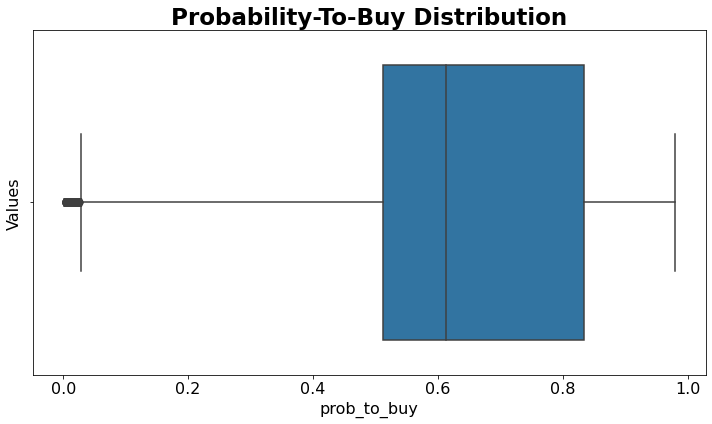

In [373]:
plt.figure(figsize=(10,6))
sns.boxplot(df_pred.prob_to_buy, orient='v')
plt.ylabel("Values",fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('prob_to_buy',fontsize=16)
plt.title("Probability-To-Buy Distribution",fontsize=23,fontweight="bold")
plt.tight_layout()
plt.show();

### Model once-off buyers

In [379]:
start_time = time.time()

query_once_off = '''

SELECT * FROM (
SELECT z.customer_id,Department,Level1,SUM(z.Recency) AS Recency,SUM(z.Frequency) AS Frequency,SUM(z.Monetary) AS Monetary,
SUM(z.Duration) AS Duration,SUM(z.Units) AS Units
FROM
(
SELECT y.customer_id, y.FY,y.Department,y.Level1,
CASE WHEN y.FY="FY20" THEN DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY) 
     WHEN y.FY="FY21" THEN DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
     ELSE DATE_DIFF(CAST("2022-06-18"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
END AS Recency, SUM(y.Frequency) AS Frequency, SUM(y.Monetary) AS Monetary,
CASE 
     WHEN (DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY))=0 
     THEN   (IF(y.FY="FY20",DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY), 
             IF(y.FY="FY21", DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
            ,DATE_DIFF(CAST("2022-06-18"AS DATE),MAX(DATE(y.Auth_Date)),DAY))))
     WHEN y.FY="FY20" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
     WHEN y.FY="FY21" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
ELSE DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
END AS Duration,
SUM(y.Units) AS Units
FROM 
(
SELECT
     customer_id,
     x.Auth_Date,
     CASE WHEN DATE(x.Auth_Date) >= '2019-04-01' AND DATE(x.Auth_Date) < '2020-04-01' THEN "FY20"
          WHEN DATE(x.Auth_Date) >= '2020-04-01' AND DATE(x.Auth_Date) < '2021-04-01' THEN "FY21"
          WHEN DATE(x.Auth_Date) >= '2021-04-01' AND DATE(x.Auth_Date) < '2022-04-01' THEN "FY22"
          WHEN DATE(x.Auth_Date) >= '2022-04-01' AND DATE(x.Auth_Date) < '2023-04-01' THEN "FY23"
      END AS FY,
      #FORMAT_DATE("%Y-%m",x.Auth_Date) AS YearMonth,
      #x.Division,
      x.Department,
       x.Level1,
      DATE_DIFF(CAST("2022-06-18" AS DATE),MAX(DATE(x.Auth_Date)),DAY) AS Recency,
      COUNT(DISTINCT x.order_id) AS Frequency,
      ROUND(SUM(x.order_item_sales),2) AS Monetary,
      IF((DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))=0,
      DATE_DIFF(CAST("2022-06-18" AS DATE),MAX(DATE(x.Auth_Date)),DAY),(DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))) AS Duration,
      SUM(x.Units) AS Units,

FROM (      

SELECT DISTINCT o.customer_id,
        #bh.bh_division AS Division, 
        bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2022-01-01" AND DATE(o.order_placed_timestamp) < "2022-06-18" 
        AND DATE(o.order_authed_timestamp) >= "2022-01-01" AND DATE(o.order_authed_timestamp) < "2022-06-18" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped') x
    #where customer_id=2005339
    #AND Division = "Home"
    GROUP BY 1,2,3,4,5
    ORDER BY Auth_Date ASC) y
    WHERE y.FY IS NOT NULL #AND customer_id=5858791
    GROUP BY 1,2,3,4) z
    GROUP BY 1,2,3) p
     WHERE Frequency=1
  
'''
df_once_off = pd.read_gbq(query_once_off, project_id='gcp-takealot', dialect='standard', credentials=credentials,progress_bar_type='tqdm_notebook')

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-06-20 20:55:31,642 : DEBUG : Requesting query... 
Query running...
2022-06-20 20:55:35,514 : DEBUG : Query running...
Job ID: 1b8c61ec-042a-4b97-a62a-bbdb11101d3d
2022-06-20 20:55:35,514 : DEBUG : Job ID: 1b8c61ec-042a-4b97-a62a-bbdb11101d3d
  Elapsed 13.99 s. Waiting...
2022-06-20 20:55:45,633 : INFO :   Elapsed 13.99 s. Waiting...
  Elapsed 24.07 s. Waiting...
2022-06-20 20:55:55,709 : INFO :   Elapsed 24.07 s. Waiting...
  Elapsed 34.34 s. Waiting...
2022-06-20 20:56:05,994 : INFO :   Elapsed 34.34 s. Waiting...
Query done.
Processed: 3.1 GB Billed: 3.1 GB
2022-06-20 20:56:13,567 : DEBUG : Query done.
Processed: 3.1 GB Billed: 3.1 GB
Standard price: $0.02 USD

2022-06-20 20:56:13,567 : DEBUG : Standard price: $0.02 USD



Downloading:   0%|          | 0/7921173 [00:00<?, ?rows/s]

Got 7921173 rows.

2022-06-20 21:05:10,102 : DEBUG : Got 7921173 rows.

Total time taken 578.46 s.
Finished at 2022-06-20 21:05:10.
2022-06-20 21:05:10,102 : INFO : Total time taken 578.46 s.
Finished at 2022-06-20 21:05:10.


--- 578.4594514369965 seconds ---


In [380]:
df_once_off['Monetary'] = round(np.floor(pd.to_numeric(df_once_off['Monetary'], errors='coerce')).astype('float64'),0)
df_once_off['Recency'] = round(np.floor(pd.to_numeric(df_once_off['Recency'], errors='coerce')).astype('float64'),0)
df_once_off['Frequency'] = round(np.floor(pd.to_numeric(df_once_off['Frequency'], errors='coerce')).astype('float64'),0)
df_once_off['Duration'] = round(np.floor(pd.to_numeric(df_once_off['Duration'], errors='coerce')).astype('float64'),0)

In [381]:
# Probability to make an order in the next 9 months (270) days
t = 270
n = 1
df_once_off['prob_to_buy'] = par_dep.conditional_probability_of_n_purchases_up_to_time(n,t, df_once_off['Frequency'].values, df_once_off['Recency'].values, df_once_off['Duration'].values)
df_once_off.sort_values(by='prob_to_buy', ascending=False).head()

,customer_id,Department,Level1,Recency,Frequency,Monetary,Duration,Units,prob_to_buy
530308,4864531,Liquor,Other,168.0000,1.0000,434.0000,168.0000,2,0.2504
7676762,8730397,Baby,Baby Equipment & Furniture,168.0000,1.0000,181.0000,168.0000,1,0.2504
7265241,7402337,Clothing & Footwear,Jewellery and Watches,168.0000,1.0000,1216.0000,168.0000,1,0.2504
1775179,5952343,Camping & Outdoor,Accessories,168.0000,1.0000,169.0000,168.0000,1,0.2504
4454160,4907111,TV & Audio,Audio,168.0000,1.0000,868.0000,168.0000,1,0.2504


In [382]:
# t = 1 (means 1 in the next day)
t = 270
df_once_off['predicted_orders'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_once_off['Frequency'], df_once_off['Recency'], df_once_off['Duration'])
df_once_off.sort_values(by='predicted_orders', ascending=False).head()

,customer_id,Department,Level1,Recency,Frequency,Monetary,Duration,Units,prob_to_buy,predicted_orders
6392554,3076988,DIY & Automotive,Home improvement,1.0000,1.0000,115.0000,1.0000,1,0.1835,13.1626
3184446,4361776,Electronic Accessories,Cellular Accessories,1.0000,1.0000,301.0000,1.0000,3,0.1835,13.1626
6747312,2094331,Baby,Nappies & Changing,1.0000,1.0000,398.0000,1.0000,2,0.1835,13.1626
5082997,2586900,Luxury Beauty,Cosmetics,1.0000,1.0000,595.0000,1.0000,1,0.1835,13.1626
6747308,992483,Baby,Nappies & Changing,1.0000,1.0000,607.0000,1.0000,1,0.1835,13.1626


In [383]:
df_once_off['predicted_gmv'] = ggf.conditional_expected_average_profit(df_once_off['Frequency'], df_once_off['Monetary'])
df_once_off.sort_values(by='predicted_gmv', ascending=False).head()

,customer_id,Department,Level1,Recency,Frequency,Monetary,Duration,Units,prob_to_buy,predicted_orders,predicted_gmv
228932,4919882,Games,Consoles,71.0000,1.0000,417363.0000,71.0000,32,0.2148,3.1827,556237.3128
247594,9920295,Mobile,Tablets & E-readers,18.0000,1.0000,417286.0000,18.0000,120,0.1915,7.2379,556134.6924
4093209,9887534,Computers & Laptops,Laptops,22.0000,1.0000,295634.0000,22.0000,20,0.1934,6.5734,394005.1384
327774,6952485,Mobile,Tablets & E-readers,19.0000,1.0000,283013.0000,19.0000,35,0.1920,7.0586,377184.7235
1007,4399408,Mobile,Tablets & E-readers,24.0000,1.0000,242045.0000,24.0000,48,0.1943,6.2875,322585.3452


In [384]:
def prob_cat(df):
    if (df['prob_to_buy'] < 0.05):
        return '<5%'
    elif ((df['prob_to_buy'] >= 0.05) and (df['prob_to_buy'] < 0.10)):
        return '5-10%'
    elif ((df['prob_to_buy'] >= 0.10) and (df['prob_to_buy'] < 0.15)):
        return '10-15%'
    elif ((df['prob_to_buy'] >= 0.15) and (df['prob_to_buy'] < 0.20)):
        return '15-20%'
    elif  ((df['prob_to_buy'] >= 0.20) and (df['prob_to_buy'] < 0.26)):
        return '20-25%'
    else:
        return '25%+'
    
        
df_once_off['prob_to_buy_cat'] = df_once_off.apply(prob_cat, axis=1)
df_once_off.head()

,customer_id,Department,Level1,Recency,Frequency,Monetary,Duration,Units,prob_to_buy,predicted_orders,predicted_gmv,prob_to_buy_cat
0,2097978,Large Appliances,Parts & Accessories,156.0000,1.0000,260.0000,156.0000,1,0.2465,1.7246,350.6575,20-25%
1,1091140,Liquor,Spirits,18.0000,1.0000,760.0000,18.0000,1,0.1915,7.2379,1017.0236,15-20%
2,699379,Baby,Mom & Baby Care,26.0000,1.0000,155.0000,26.0000,1,0.1952,6.0269,210.7206,15-20%
3,1315424,Liquor,Non-alcoholic,165.0000,1.0000,304.0000,165.0000,2,0.2494,1.6461,409.2977,20-25%
4,7269778,Baby,Mom & Baby Care,144.0000,1.0000,51.0000,144.0000,1,0.2424,1.8419,72.1164,20-25%


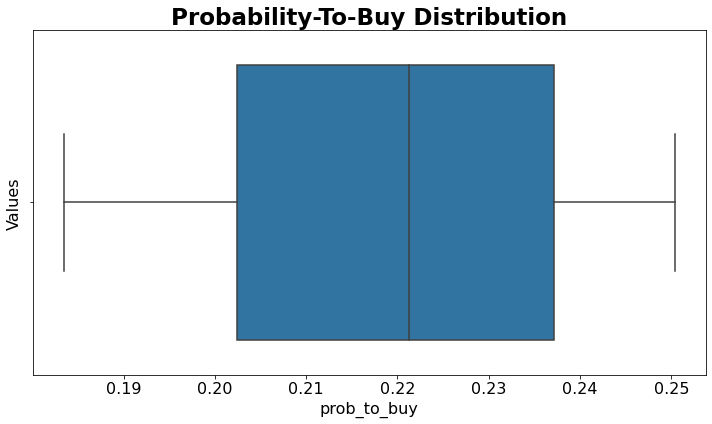

In [391]:
plt.figure(figsize=(10,6))
sns.boxplot(df_once_off.prob_to_buy, orient='v')
plt.ylabel("Values",fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('prob_to_buy',fontsize=16)
plt.title("Probability-To-Buy Distribution",fontsize=23,fontweight="bold")
plt.tight_layout()
plt.show();

In [388]:
df_1p = df_once_off.groupby(['Department','prob_to_buy_cat','Cust_Seq_Cat']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Units':'mean',
    'prob_to_buy':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'sum',
    'customer_id':'nunique'
}).reset_index() 
df_1p

,Department,prob_to_buy_cat,Cust_Seq_Cat,Recency,Frequency,Monetary,Units,prob_to_buy,predicted_orders,predicted_gmv,customer_id
0,Baby,15-20%,1-->2,19.4953,1.0000,378.9994,1.4399,0.1922,431207.1665,29589055.3899,48348
1,Baby,20-25%,1-->2,104.9220,1.0000,359.7523,1.3986,0.2276,516212.6403,95502894.6562,158534
2,Beauty,15-20%,1-->2,17.6898,1.0000,174.6934,1.1204,0.1913,2124.1402,64928.8604,274
3,Beauty,20-25%,1-->2,62.8636,1.0000,184.6818,1.1023,0.2108,339.1014,22024.5072,88
4,Books,15-20%,1-->2,20.1155,1.0000,283.8536,1.4536,0.1925,346810.2731,18132237.4990,45936
...,...,...,...,...,...,...,...,...,...,...,...
64,TV & Audio,20-25%,1-->2,103.3111,1.0000,1076.4383,1.1192,0.2270,630523.0146,342920598.9830,223029
65,Toys,15-20%,1-->2,19.4488,1.0000,375.1536,1.3731,0.1921,508443.5093,34485776.4487,61387
66,Toys,20-25%,1-->2,103.8343,1.0000,371.3896,1.3715,0.2272,651981.5066,123556172.9181,212576
67,Wearables and GPS,15-20%,1-->2,19.0454,1.0000,1067.2629,1.0952,0.1920,171364.5524,32560384.1737,22724


In [356]:
# Export to google sheets
start_time = time.time()

file = 'C:/Users/mncedisi.mncwabe/Downloads/tal-production-data-4390ad039b75.json'
sheet_id = '1WIHc4M-vJzN_ZQIYzQRoGUMY4AUNrYC3nGEQ3FWf_mM'
sheet_name = 'Customers - Repeat Purchasers'

def write_to_gsheet(service_file_path, spreadsheet_id, sheet_name, data_df):
    gc = pygsheets.authorize(service_file=service_file_path)
    sh = gc.open_by_key(spreadsheet_id)
    try:
        sh.add_worksheet(sheet_name)
    except:
        pass
    wks_write = sh.worksheet_by_title(sheet_name)
    wks_write.clear('A1',None,'*')
    wks_write.set_dataframe(data_df, (1,1), encoding='utf-8', fit=True)
    wks_write.frozen_rows = 1

write_to_gsheet(file, sheet_id, sheet_name, df_once_off_head)

print("--- %s seconds ---" % (time.time() - start_time))

--- 205.4846773147583 seconds ---


### 2 step predictions - Division

In [474]:
df_high_freq = df_pred

In [ ]:
# Probability to make 2 order in the next 270 days
t = 270
n = 2
df_high_freq['prob_to_buy'] = par.conditional_probability_of_n_purchases_up_to_time(n,t, df_high_freq['Frequency'], df_high_freq['Recency'], df_high_freq['Duration'])
df_high_freq.sort_values(by='prob_to_buy', ascending=False).head()

In [476]:
t = 270
df_high_freq['predicted_orders'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,df_high_freq['Frequency'], df_high_freq['Recency'], df_high_freq['Duration'])
df_high_freq.sort_values(by='predicted_orders', ascending=False).head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,...,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy,Cust_Seq_Cat,prob_cat
11167599,907645,FY22,Media,1.0000,4.0000,1066.0000,1.0000,After_Covid,2,4,...,1,2431,10,Rising Stars,47.9425,0.9507,1137.7938,0.3133,4-->5 Purchaser,30-40%
10082754,9311188,FY22,Consumables,1.0000,4.0000,479.0000,1.0000,After_Covid,3,4,...,1,3421,10,Deal Hunters,47.9425,0.9507,511.7170,0.3133,4-->5 Purchaser,30-40%
4301948,494895,FY22,Lifestyle,1.0000,4.0000,1422.0000,1.0000,After_Covid,1,4,...,1,1441,10,Rising Stars,47.9425,0.9507,1517.4929,0.3133,4-->5 Purchaser,30-40%
14400700,9029222,FY22,Home,1.0000,4.0000,885.0000,1.0000,After_Covid,3,4,...,1,3421,10,Deal Hunters,47.9425,0.9507,944.7446,0.3133,4-->5 Purchaser,30-40%
2570007,7814695,FY22,Lifestyle,1.0000,4.0000,7905.0000,1.0000,After_Covid,1,4,...,1,1441,10,Rising Stars,47.9425,0.9507,8432.0693,0.3133,4-->5 Purchaser,30-40%


In [477]:
# Probability to make 2 order in the next 270 days
t = 270
n = 2
df_high_freq['prob_to_buy'] = par.conditional_probability_of_n_purchases_up_to_time(n,t, df_high_freq['Frequency'], df_high_freq['Recency'], df_high_freq['Duration'])
df_high_freq.sort_values(by='prob_to_buy', ascending=False).head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,...,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy,Cust_Seq_Cat,prob_cat
3439564,7723889,FY22,Electronics,391.0000,4.0000,17.0000,391.0000,After_Covid,1,4,...,4,1414,10,Promising,2.7382,0.9507,18.9614,0.2021,4-->5 Purchaser,60-70%
1491830,7558845,FY22,Electronics,389.0000,4.0000,17.0000,389.0000,After_Covid,1,4,...,4,1414,10,Promising,2.7511,0.9507,18.9614,0.2020,4-->5 Purchaser,60-70%
9499476,6935579,FY22,Media,389.0000,4.0000,1154.0000,389.0000,After_Covid,1,4,...,4,1444,13,Rising Stars,2.7511,0.9507,1231.6520,0.2020,4-->5 Purchaser,60-70%
17607184,7731286,FY22,Electronics,389.0000,4.0000,12387.0000,389.0000,After_Covid,1,4,...,4,1444,13,Rising Stars,2.7511,0.9507,13212.4382,0.2020,4-->5 Purchaser,60-70%
16244193,7675899,FY22,Home,389.0000,4.0000,2441.0000,389.0000,After_Covid,1,4,...,4,1434,12,Rising Stars,2.7511,0.9507,2604.3282,0.2020,4-->5 Purchaser,60-70%


In [478]:
def cust_seq(df):
    if (df['Frequency'] == 2) :
        return '2-->4 Purchaser'
    elif (df['Frequency'] == 3):
        return '3-->5 Purchaser'
    elif (df['Frequency'] == 4):
        return '4-->6 Purchaser'
    elif (df['Frequency'] == 5):
        return '5-->7 Purchaser'
    elif (df['Frequency'] == 6):
        return '6-->8 Purchaser'
    elif (df['Frequency'] == 7):
        return '7-->9 Purchaser'
    elif (df['Frequency'] == 8):
        return '8-->10 Purchaser'
    elif (df['Frequency'] == 9):
        return '9-->11 Purchaser'
    elif (df['Frequency'] == 10):
        return '10-->12 Purchaser'
    elif (df['Frequency'] == 11):
        return '11-->13 Purchaser'
    elif (df['Frequency'] == 12):
        return '12-->14 Purchaser'
    elif (df['Frequency'] == 13):
        return '13-->15 Purchaser'
    elif (df['Frequency'] == 14):
        return '14-->16 Purchaser'
    elif (df['Frequency'] == 15):
        return '15-->17 Purchaser'
    elif (df['Frequency'] == 16):
        return '16-->18 Purchaser'
    elif (df['Frequency'] == 17):
        return '17-->19 Purchaser'
    elif (df['Frequency'] == 18):
        return '18-->20 Purchaser'
    elif (df['Frequency'] == 19):
        return '19-->21 Purchaser'
    else:
        return '20 -->22+ Purchaser'
    
    
df_high_freq['Cust_Seq_Cat'] = df_high_freq.apply(cust_seq, axis=1)
df_high_freq.head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,...,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy,Cust_Seq_Cat,prob_cat
19,1191065,FY22,Home,30.0000,2.0000,2346.0000,30.0000,After_Covid,2,2,...,1,2231,8,Promising,10.5896,0.8983,2682.4026,0.1606,2-->4 Purchaser,50-60%
41,851975,FY22,Home,80.0000,3.0000,5594.0000,309.0000,After_Covid,3,3,...,4,3344,14,Promising,0.4091,0.1469,6102.9264,0.0569,3-->5 Purchaser,80-90%
45,1548680,FY22,Home,5.0000,2.0000,4509.0000,5.0000,After_Covid,2,2,...,1,2241,9,Promising,20.9453,0.8983,5153.9249,0.1530,2-->4 Purchaser,40-50%
70,331641,FY22,Home,58.0000,2.0000,2259.0000,60.0000,After_Covid,3,2,...,1,3231,9,Promising,6.7509,0.8917,2582.9932,0.1671,2-->4 Purchaser,50-60%
79,2433402,FY22,Home,71.0000,2.0000,380.0000,105.0000,After_Covid,3,2,...,2,3212,8,Promising,3.9345,0.7886,435.9796,0.1599,2-->4 Purchaser,60-70%


In [479]:
def prob_cat(df):
    if (df['prob_to_buy'] < 0.1) :
        return '<10%'
    elif ((df['prob_to_buy'] >= 0.1) and (df['prob_to_buy'] < 0.2)):
        return '10-20%'
    elif ((df['prob_to_buy'] >= 0.2) and (df['prob_to_buy'] < 0.3)):
        return '20-30%'
    elif ((df['prob_to_buy'] >= 0.3) and (df['prob_to_buy'] < 0.4)):
        return '30-40%'
    elif ((df['prob_to_buy'] >= 0.4) and (df['prob_to_buy'] < 0.5)):
        return '40-50%'   
    elif ((df['prob_to_buy'] >= 0.5) and (df['prob_to_buy'] < 0.6)):
        return '50-60%'
    elif ((df['prob_to_buy'] >= 0.6) and (df['prob_to_buy'] < 0.7)):
        return '60-70%'
    elif ((df['prob_to_buy'] >= 0.7) and (df['prob_to_buy'] < 0.8)):
        return '70-80%'
    elif ((df['prob_to_buy'] >= 0.8) and (df['prob_to_buy'] < 0.9)):
        return '80-90%'    
    else:
        return '>90%'
    

df_high_freq['prob_cat'] = df_high_freq.apply(prob_cat, axis=1)
df_high_freq.head()

,customer_id,FY,Division,Recency,Frequency,Monetary,Duration,is_Covid,R,F,...,D,RFMD_Score,RFMD,RFMD_Segment,predicted_orders,prob_active,predicted_gmv,prob_to_buy,Cust_Seq_Cat,prob_cat
19,1191065,FY22,Home,30.0000,2.0000,2346.0000,30.0000,After_Covid,2,2,...,1,2231,8,Promising,10.5896,0.8983,2682.4026,0.1606,2-->4 Purchaser,10-20%
41,851975,FY22,Home,80.0000,3.0000,5594.0000,309.0000,After_Covid,3,3,...,4,3344,14,Promising,0.4091,0.1469,6102.9264,0.0569,3-->5 Purchaser,<10%
45,1548680,FY22,Home,5.0000,2.0000,4509.0000,5.0000,After_Covid,2,2,...,1,2241,9,Promising,20.9453,0.8983,5153.9249,0.1530,2-->4 Purchaser,10-20%
70,331641,FY22,Home,58.0000,2.0000,2259.0000,60.0000,After_Covid,3,2,...,1,3231,9,Promising,6.7509,0.8917,2582.9932,0.1671,2-->4 Purchaser,10-20%
79,2433402,FY22,Home,71.0000,2.0000,380.0000,105.0000,After_Covid,3,2,...,2,3212,8,Promising,3.9345,0.7886,435.9796,0.1599,2-->4 Purchaser,10-20%


In [480]:
df_high_freq_grp = df_high_freq.groupby(['Division','Cust_Seq_Cat','prob_cat']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'prob_to_buy':'mean',
    'prob_active':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'sum',
    'customer_id':'nunique'
}).reset_index() 
df_high_freq_grp

,Division,Cust_Seq_Cat,prob_cat,Recency,Frequency,Monetary,Duration,prob_to_buy,prob_active,predicted_orders,predicted_gmv,customer_id
0,Consumables,2-->4 Purchaser,10-20%,68.3496,2.0000,842.5842,85.7514,0.1602,0.8419,2478811.9883,299879970.6343,310903
1,Consumables,2-->4 Purchaser,<10%,56.0733,2.0000,827.7516,265.9615,0.0716,0.2141,13255.1686,24672578.6667,26037
2,Consumables,3-->5 Purchaser,10-20%,90.6632,3.0000,1317.2077,121.9683,0.1511,0.8157,1022573.6491,209264575.1475,145534
3,Consumables,3-->5 Purchaser,<10%,57.8022,3.0000,1283.9350,263.7418,0.0634,0.1323,17909.0168,55896424.5690,39880
4,Consumables,4-->6 Purchaser,10-20%,105.7724,4.0000,1817.9538,141.3402,0.1384,0.8060,479010.9575,130539213.7444,67295
5,Consumables,4-->6 Purchaser,20-30%,372.0000,4.0000,10769.0000,372.0000,0.2009,0.9507,2.8657,11486.7271,1
6,Consumables,4-->6 Purchaser,<10%,60.8799,4.0000,1792.4645,258.5573,0.0536,0.0946,20570.2612,90223994.9656,47173
7,Electronics,2-->4 Purchaser,10-20%,68.7631,2.0000,1977.2034,86.6109,0.1599,0.8414,2740697.6454,757840429.5346,335179
8,Electronics,2-->4 Purchaser,<10%,56.1629,2.0000,1951.6243,268.3927,0.0707,0.2117,15573.8655,69490765.8287,31137
9,Electronics,3-->5 Purchaser,10-20%,90.6356,3.0000,3101.6091,122.4226,0.1507,0.8166,1027187.8734,480433642.3121,141960


### 2 step predictions - Department

In [493]:
df_pred_dep.head()

,customer_id,FY,Division,Department,Level1,Recency,Frequency,Monetary,Duration,is_Covid,...,M,D,RFMD_Score,RFMD,RFMD_Segment,prob_to_buy,predicted_orders,predicted_gmv,Cust_Seq_Cat,prob_cat
2,5636870,FY22,Home,DIY & Automotive,Smart Energy Solutions,149.0000,1.0000,173.0000,149.0000,After_Covid,...,1,2,3112,7,Promising,0.1568,1.7911,234.7098,20 -->22+ Purchaser,10-20%
6,7172446,FY22,Home,DIY & Automotive,Home Security,331.0000,1.0000,886.0000,331.0000,After_Covid,...,3,4,1134,9,Promising,0.1344,0.9007,1184.9479,20 -->22+ Purchaser,10-20%
9,1779975,FY22,Media,Stationery,Adhesives,123.0000,1.0000,68.0000,123.0000,After_Covid,...,1,2,3112,7,Promising,0.1589,2.0924,94.7729,20 -->22+ Purchaser,10-20%
10,5457,FY22,Home,DIY & Automotive,Home Security,83.0000,3.0000,5965.0000,83.0000,After_Covid,...,4,2,3442,13,Promising,0.1604,7.7807,6507.6039,3-->5 Purchaser,10-20%
12,110297,FY22,Consumables,Liquor,Beer,155.0000,1.0000,500.0000,155.0000,After_Covid,...,3,2,2132,8,Promising,0.1562,1.7337,670.5132,20 -->22+ Purchaser,10-20%


In [485]:
t = 270
n = np.array([1, 2])
df_pred_dep['prob_to_buy'] = par.conditional_probability_of_n_purchases_up_to_time(n,t, df_pred_dep['Frequency'], df_pred_dep['Recency'], df_pred_dep['Duration'])

In [486]:
t = 270
n = np.array([1, 2])
df_pred_dep['predicted_orders'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,df_pred_dep['Frequency'], df_pred_dep['Recency'], df_pred_dep['Duration'])

In [487]:
df_pred_dep['predicted_gmv'] = ggf.conditional_expected_average_profit(df_pred_dep['Frequency'], df_pred_dep['Monetary'])

In [488]:
df_pred_dep['Cust_Seq_Cat'] = df_pred_dep.apply(cust_seq, axis=1)
df_pred_dep['prob_cat'] = df_pred_dep.apply(prob_cat, axis=1)

In [537]:
df_2step_dep = df_pred_dep.groupby(['Department','Cust_Seq_Cat','prob_cat']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'prob_to_buy':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'sum',
    'customer_id':'nunique'
}).reset_index() 

In [494]:
df_pred_dep.to_gbq(destination_table='tal-production-marketing.rfmd_preds.2step_preds_dep',
               project_id='tal-bq-job-default',
               credentials=cre_marketing,
               chunksize=100000,
               progress_bar=True,
               if_exists='replace')

18243650 out of 18243650 rows loaded.
18243650 out of 18243650 rows loaded.
100%|██████████| 1/1 [00:00<00:00, 64.00it/s]


In [470]:
import pickle
#save models
bgf.save_model('bgf.pkl')
par.save_model('par.pkl')
ggf.save_model('ggf.pkl')


#load models

#bgf_loaded = BetaGeoFitter()
#bgf_loaded.load_model('bgf.pkl')
#bgf_loaded

#par_loaded = ParetoNBDFitter()
#par_loaded.load_model('par.pkl')
#par_loaded

#ggf_loaded = GammaGammaFitter()
#ggf_loaded.load_model('ggf.pkl')
#ggf_loaded